# import Statments

In [ ]:
import pandas as pd                    #  data handling
import numpy as np                     #  numerical operations
import matplotlib.pyplot as plt        #  plotting
import seaborn as sns                  #  static data visualization
import plotly.express as px            #  interactive plots
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt, iirnotch
import math
from scipy.stats import zscore
from scipy.stats import median_abs_deviation
import missingno as msno
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import ADASYN
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, average_precision_score
)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import precision_score, recall_score
'''
import warnings
warnings.filterwarnings('ignore')     # ignore warnings to keep output clean
'''


"\nimport warnings\nwarnings.filterwarnings('ignore')     # ignore warnings to keep output clean\n"

In [ ]:
!pip install CatBoost

In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
from catboost import Pool
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import cohen_kappa_score, balanced_accuracy_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay


# Load Data

In [ ]:
EMG_df = pd.read_excel(
    "/content/EMG Data NAAFH 3Ver3.xlsx",
    keep_default_na=True,
    na_values=['NA', 'N/A', '']   # Only these become NaN
)

# Keep "None" as text (not missing)
cols = ['comorbidities', 'medications', 'surgery_history','injury_type']

for c in cols:
    EMG_df[c] = EMG_df[c].fillna("None")

# Preview
EMG_df.head()



ID  age sex   BMI dominant_side affected_limb limb_temperature_c  \
0   1   42   M  26.9         Right    Left Elbow                 37   
1   2   41   F  33.7         Right    Left Wrist               35.8   
2   3   24   M  37.1         Right   Right Wrist               35.7   
3   4   52   M  26.4         Right   Right Wrist                 36   
4   5   47   M  25.9         Right   Right Wrist               35.7   

  affected_limb_dominance                injury_type time_since_injury_months  \
0            Non-dominant  Compression – Neuropraxia                        1   
1            Non-dominant    Traumatic – Neuropraxia                        5   
2                Dominant   Entrapment – Neurotmesis                       10   
3                Dominant  Compression – Neuropraxia                        6   
4                Dominant    Traumatic – Axonotmesis                       10   

   ... Insertional_Activity Positive_Sharp_Waves  Fibrillation Fasciculation  \
0  ...            Increased         Present (2+)  Present (1+)  Present (1+)   
1  ...     Mildly increased         Present (1+)  Present (1+)        Absent   
2  ...            Increased         Present (2+)  Present (1+)  Present (1+)   
3  ...            Increased         Present (1+)  Present (1+)  Present (1+)   
4  ...            Increased         Present (1+)  Present (3+)  Present (2+)   

  MUAP_Amplitude (mV) MUAP_Duration (ms) Recruitment_Pattern Polyphasic_Units  \
0                 3.3                9.1             Reduced               43   
1                 5.2                9.2             Reduced               23   
2                 1.9               14.2    Severely reduced               61   
3                 3.7               10.9             Reduced               41   
4                 1.5                9.0    Severely reduced               35   

  Voluntary_Activation_Quality Severity_Label  
0                      Partial       Moderate  
1                       Normal           Mild  
2                      Minimal         Severe  
3                      Partial       Moderate  
4                      Minimal         Severe  

[5 rows x 29 columns]

# EDA

## Data Structure Understanding

In [ ]:
print("Shape of the dataset:", EMG_df.shape)


Shape of the dataset: (238, 29)


In [ ]:
print("Columns:", EMG_df.columns)


Columns: Index(['ID', 'age', 'sex', 'BMI', 'dominant_side', 'affected_limb',
       'limb_temperature_c', 'affected_limb_dominance', 'injury_type',
       'time_since_injury_months', 'comorbidities', 'medications',
       'surgery_history', 'diagnosis', 'muscle_name', 'side', 'Electrode_Type',
       'Electrode_Depth', 'Contraction_Level', 'Insertional_Activity',
       'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation',
       'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Recruitment_Pattern',
       'Polyphasic_Units', 'Voluntary_Activation_Quality', 'Severity_Label'],
      dtype='object')


In [ ]:
print("\nBasic statistics:\n", EMG_df.describe())


Basic statistics:
                ID         age         BMI  MUAP_Amplitude (mV)  \
count  238.000000  238.000000  238.000000           238.000000   
mean   119.500000   42.357143   27.261345             4.244958   
std     68.848868   11.929583    4.909031             1.476581   
min      1.000000   18.000000   18.000000             0.800000   
25%     60.250000   34.000000   23.625000             3.200000   
50%    119.500000   42.000000   26.800000             4.000000   
75%    178.750000   50.000000   30.850000             5.275000   
max    238.000000   77.000000   42.000000             9.000000   

       MUAP_Duration (ms)  Polyphasic_Units  
count          238.000000        238.000000  
mean             9.681092         30.428571  
std              1.920514         20.328763  
min              6.000000          0.000000  
25%              8.300000         12.000000  
50%              9.300000         27.500000  
75%             10.975000         46.000000  
max             1

In [ ]:
# Data Info + Memory Usage

EMG_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            238 non-null    int64  
 1   age                           238 non-null    int64  
 2   sex                           238 non-null    object 
 3   BMI                           238 non-null    float64
 4   dominant_side                 238 non-null    object 
 5   affected_limb                 238 non-null    object 
 6   limb_temperature_c            238 non-null    object 
 7   affected_limb_dominance       238 non-null    object 
 8   injury_type                   238 non-null    object 
 9   time_since_injury_months      238 non-null    object 
 10  comorbidities                 238 non-null    object 
 11  medications                   238 non-null    object 
 12  surgery_history               238 non-null    object 
 13  diagn

In [ ]:
#these are Numerical Features BUT beacuse of the Unknown values they considered as object

for col in ['limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth']:
    print(col, EMG_df[col].unique())


limb_temperature_c [37 35.8 35.7 36 36.6 36.1 36.3 35.9 36.2 35.1 35.4 35.6 36.4 36.5 34.9
 36.7 35.5 'Unknown' 36.9 34.5 35.3 35.2 37.5 37.4 36.8 35 37.1 34.8 37.3]
time_since_injury_months [1 5 10 6 2 4 0 3 8 14 7 15 9 20 12 16 11 22 'Unknown' 13]
Electrode_Depth [1.6 2.4 2.5 1 0.5 2.3 1.8 1.4 1.7 1.3 2.1 2.7 1.1 2.2 1.5 1.2 2 3 2.6 2.8
 'Unknown' 1.9 2.9]


In [ ]:
numeric_fix_cols = ['limb_temperature_c',
                    'time_since_injury_months',
                    'Electrode_Depth']

for col in numeric_fix_cols:
    # Create indicator column for missing values
    EMG_df[col + '_missing'] = EMG_df[col].eq('Unknown') | EMG_df[col].isna()

    # Replace "Unknown" with NaN
    EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)

    # Convert column to numeric
    EMG_df[col] = pd.to_numeric(EMG_df[col], errors='coerce')

/tmp/ipython-input-1950857534.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)
/tmp/ipython-input-1950857534.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)
/tmp/ipython-input-1950857534.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.s

In [ ]:
#Count numeric & categorical features

# Select numeric & categorical features
numeric_features = EMG_df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'])
categorical_features = EMG_df.select_dtypes(include=['object', 'category'])

# column counts
print("Number of Numeric features:", len(numeric_features.columns))
print("Number of Categorical features:", len(categorical_features.columns))

# column names
print("\nNumeric feature:")
print(list(numeric_features.columns))

print("\nCategorical feature:")
print(list(categorical_features.columns))


Number of Numeric features: 8
Number of Categorical features: 20

Numeric feature:
['age', 'BMI', 'limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units']

Categorical feature:
['sex', 'dominant_side', 'affected_limb', 'affected_limb_dominance', 'injury_type', 'comorbidities', 'medications', 'surgery_history', 'diagnosis', 'muscle_name', 'side', 'Electrode_Type', 'Contraction_Level', 'Insertional_Activity', 'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation', 'Recruitment_Pattern', 'Voluntary_Activation_Quality', 'Severity_Label']


## Descriptive Summary Statistics

In [ ]:
# Summary stats for all numeric features

numeric_cols = EMG_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('ID')

EMG_df[numeric_cols].describe().T  # Transpose for readability

count       mean        std   min     25%   50%  \
age                       238.0  42.357143  11.929583  18.0  34.000  42.0   
BMI                       238.0  27.261345   4.909031  18.0  23.625  26.8   
limb_temperature_c        237.0  35.998734   0.554678  34.5  35.700  36.0   
time_since_injury_months  235.0   4.710638   4.355134   0.0   1.000   4.0   
Electrode_Depth           237.0   1.729958   0.759508   0.5   1.200   1.9   
MUAP_Amplitude (mV)       238.0   4.244958   1.476581   0.8   3.200   4.0   
MUAP_Duration (ms)        238.0   9.681092   1.920514   6.0   8.300   9.3   
Polyphasic_Units          238.0  30.428571  20.328763   0.0  12.000  27.5   

                             75%   max  
age                       50.000  77.0  
BMI                       30.850  42.0  
limb_temperature_c        36.300  37.5  
time_since_injury_months   7.000  22.0  
Electrode_Depth            2.300   3.0  
MUAP_Amplitude (mV)        5.275   9.0  
MUAP_Duration (ms)        10.975  16.0  
Polyphasic_Units          46.000  84.0

In [ ]:
print( type(numeric_features))
print( type(numeric_cols) )

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.indexes.base.Index'>


## Target Label Distribution

In [ ]:
print("Severity distribution:")
print(EMG_df['Severity_Label'].value_counts())


Severity distribution:
Severity_Label
Moderate    87
Mild        82
Normal      46
Severe      23
Name: count, dtype: int64


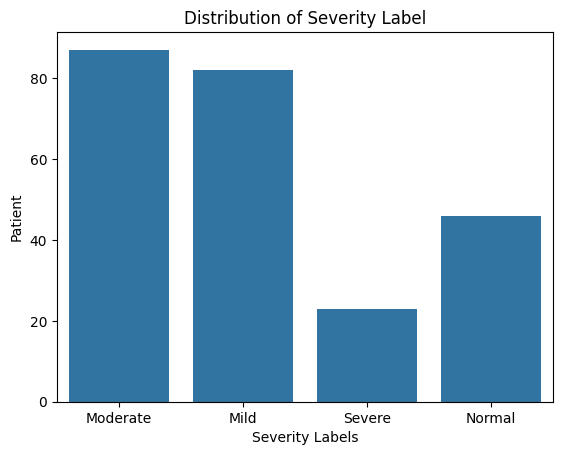

In [ ]:
sns.countplot(data=EMG_df, x='Severity_Label')

plt.title('Distribution of Severity Label')
plt.xlabel("Severity Labels")
plt.ylabel("Patient")
plt.show()


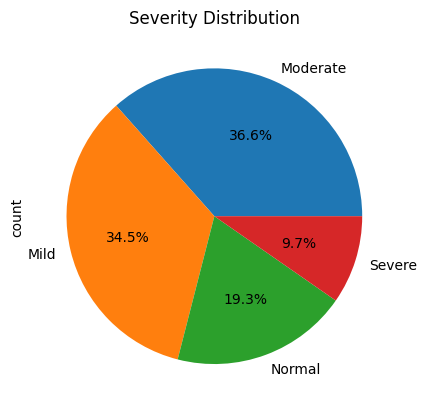

In [ ]:
EMG_df['Severity_Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Severity Distribution")
plt.show()


## Correlation Analysis

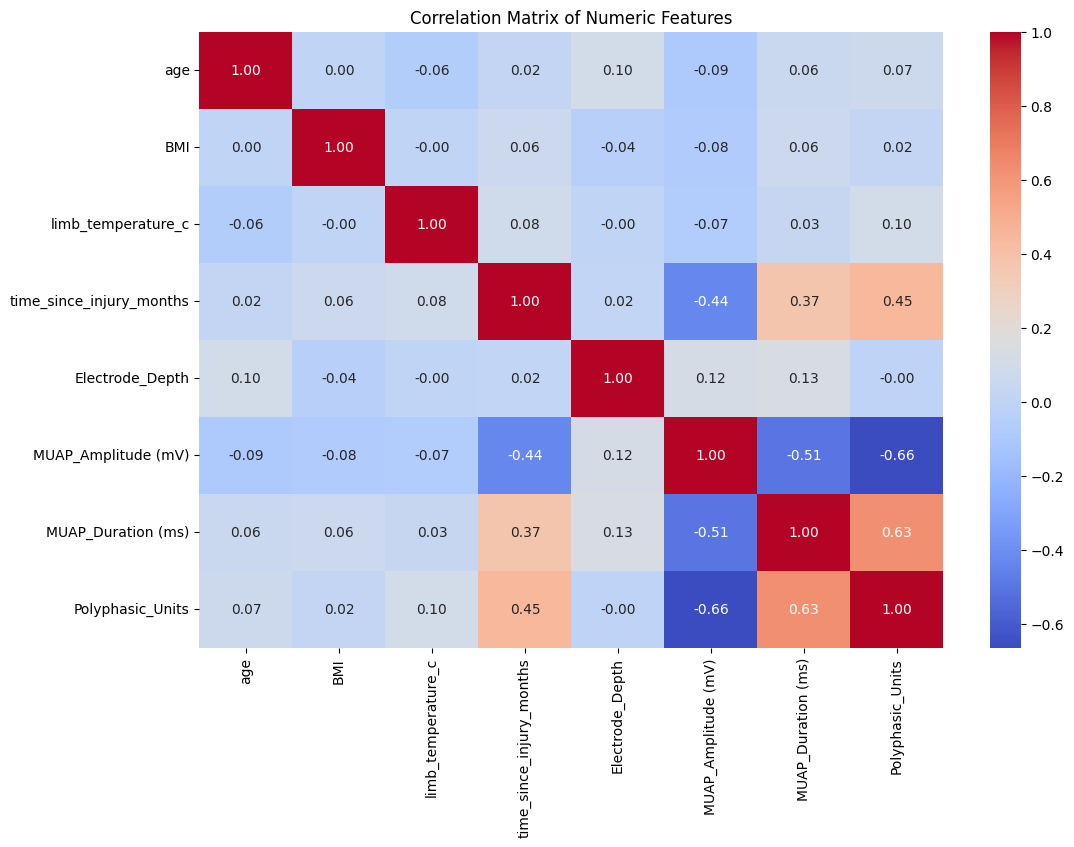

In [ ]:
# Correlation matrix to detect collinear features

corr = EMG_df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()


## Distribution of Each EMG Feature

### Numarical Features Distribution

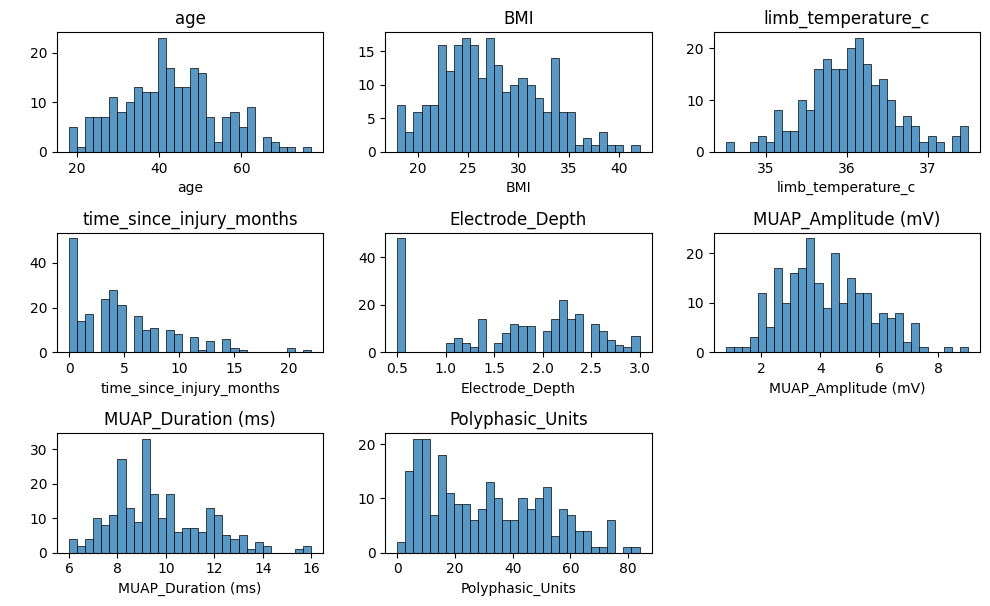

In [ ]:
# number of charts per row
cols = 3

# round up the number of rows ; Ensures enough rows to display all features.
rows = math.ceil( len(numeric_features) / cols)

# Create Creates a new figure for all subplots ( witdh,height  )
plt.figure(figsize=(10, rows * 2))


for i, col in enumerate(numeric_features, 1):
    #Creates the i-th subplot in a grid of rows × cols.
    plt.subplot(rows, cols, i)

    # draws histogram + dropna() removes missing values before plottin + splits the data range into 30 buckets +  no density curve
    sns.histplot(EMG_df[col].dropna(), bins=30, kde=False)
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)
    plt.ylabel(' ', fontsize=10)

plt.tight_layout()
plt.show()


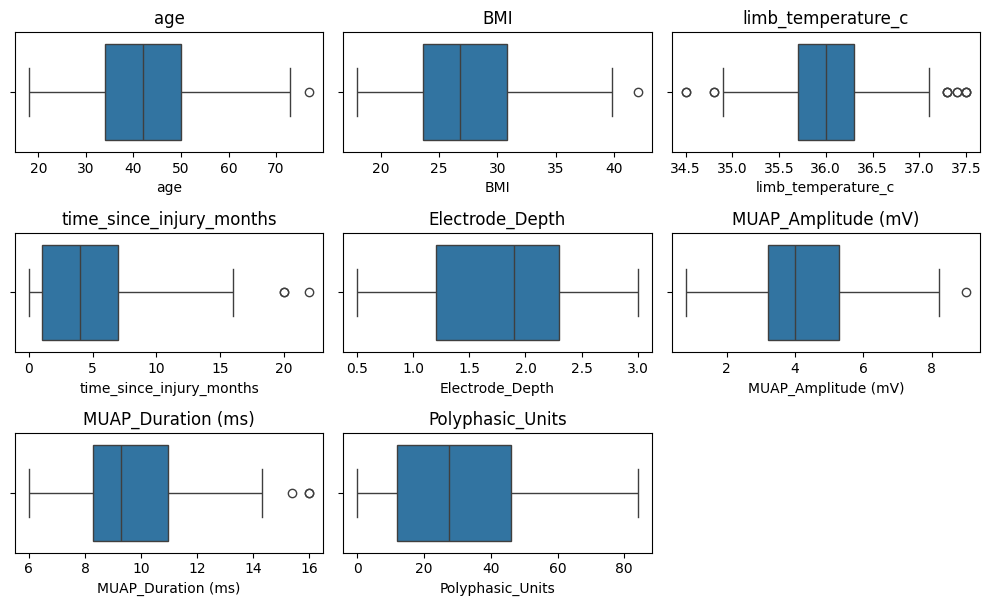

In [ ]:
#  Boxplot by Nerve or Severity

plt.figure(figsize=(10, rows * 2))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=EMG_df[col].dropna())
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)

plt.tight_layout()
plt.show()


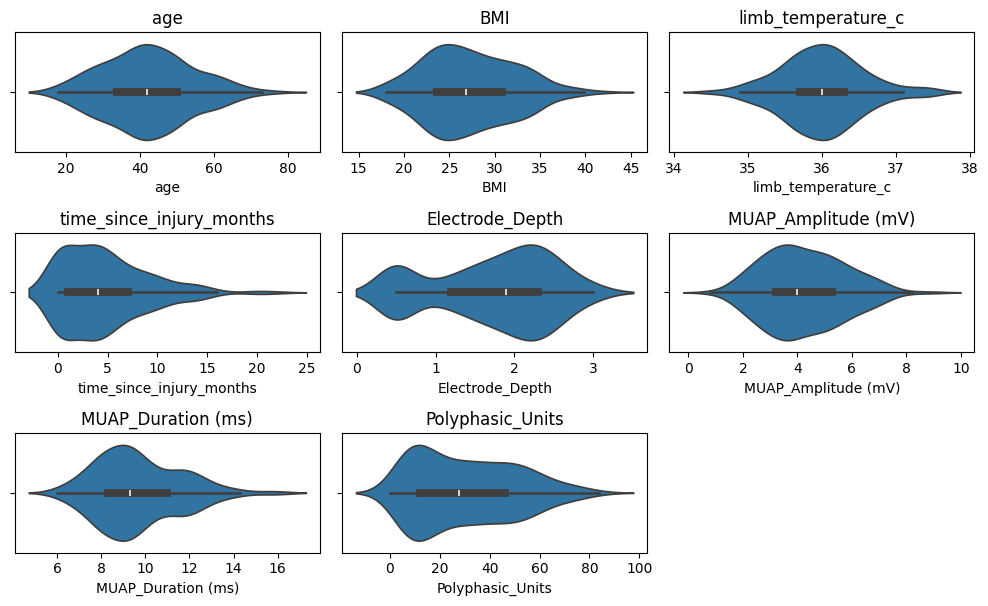

In [ ]:
#Violin Plot
plt.figure(figsize=(10, rows * 2))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.violinplot(x=EMG_df[col].dropna())
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)

plt.tight_layout()
plt.show()


### Catagorical Features Distribution

/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `

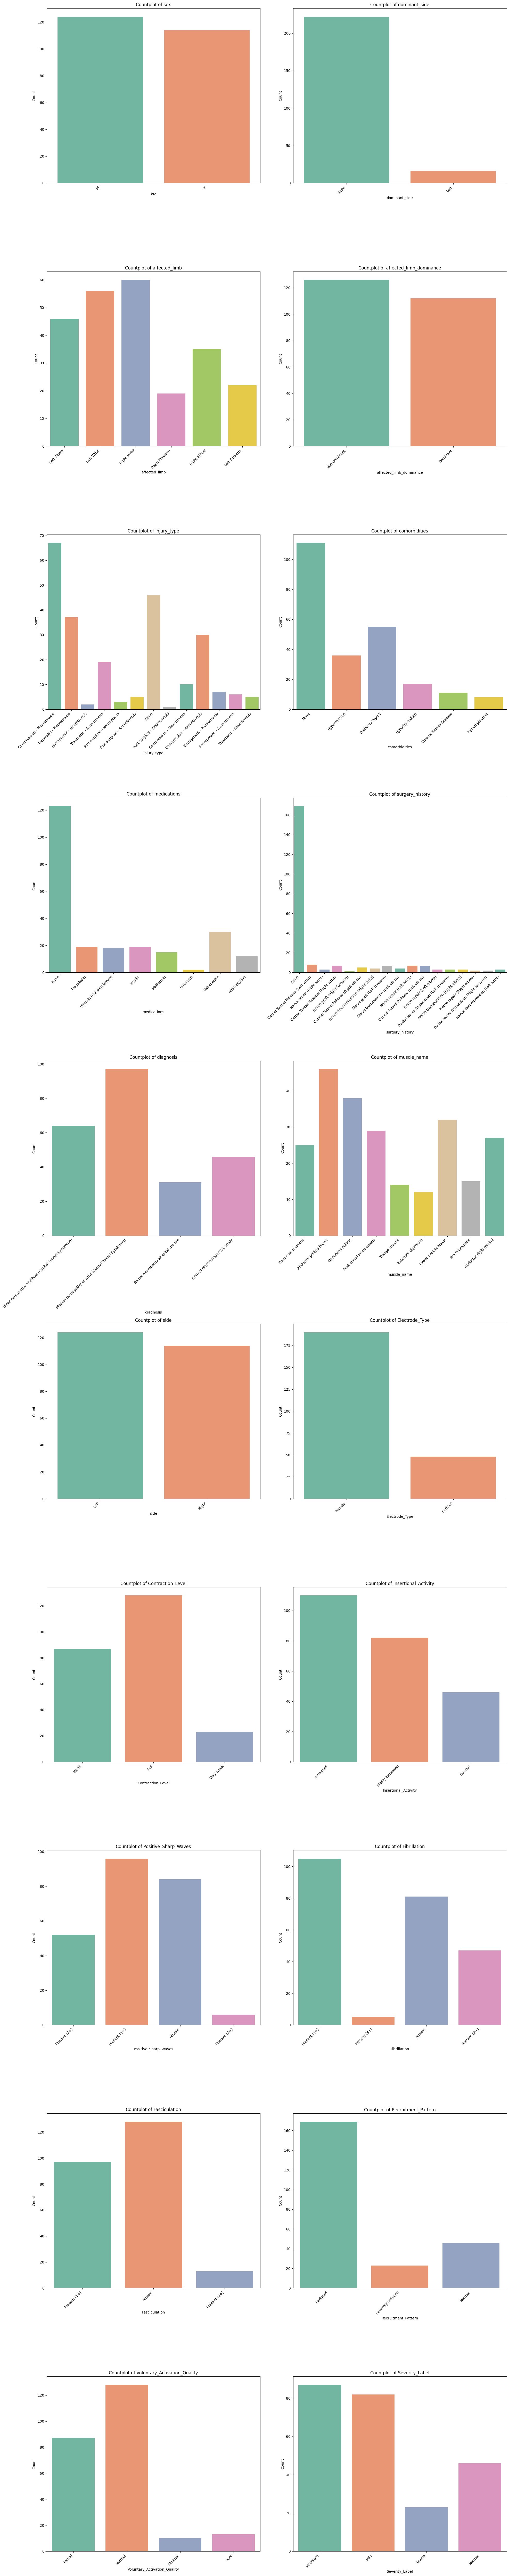

In [ ]:
# Count Plot

# Select categorical columns
categorical_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

# Number of categorical features
n_cat = len(categorical_cols)

# Layout
cols = 2   # number of plots per row
rows = math.ceil(n_cat / cols)

# Create figure
plt.figure(figsize=(20, rows * 10))

# Loop for subplots
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=EMG_df, x=col, palette='Set2')
    plt.title(f'Countplot of {col}', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


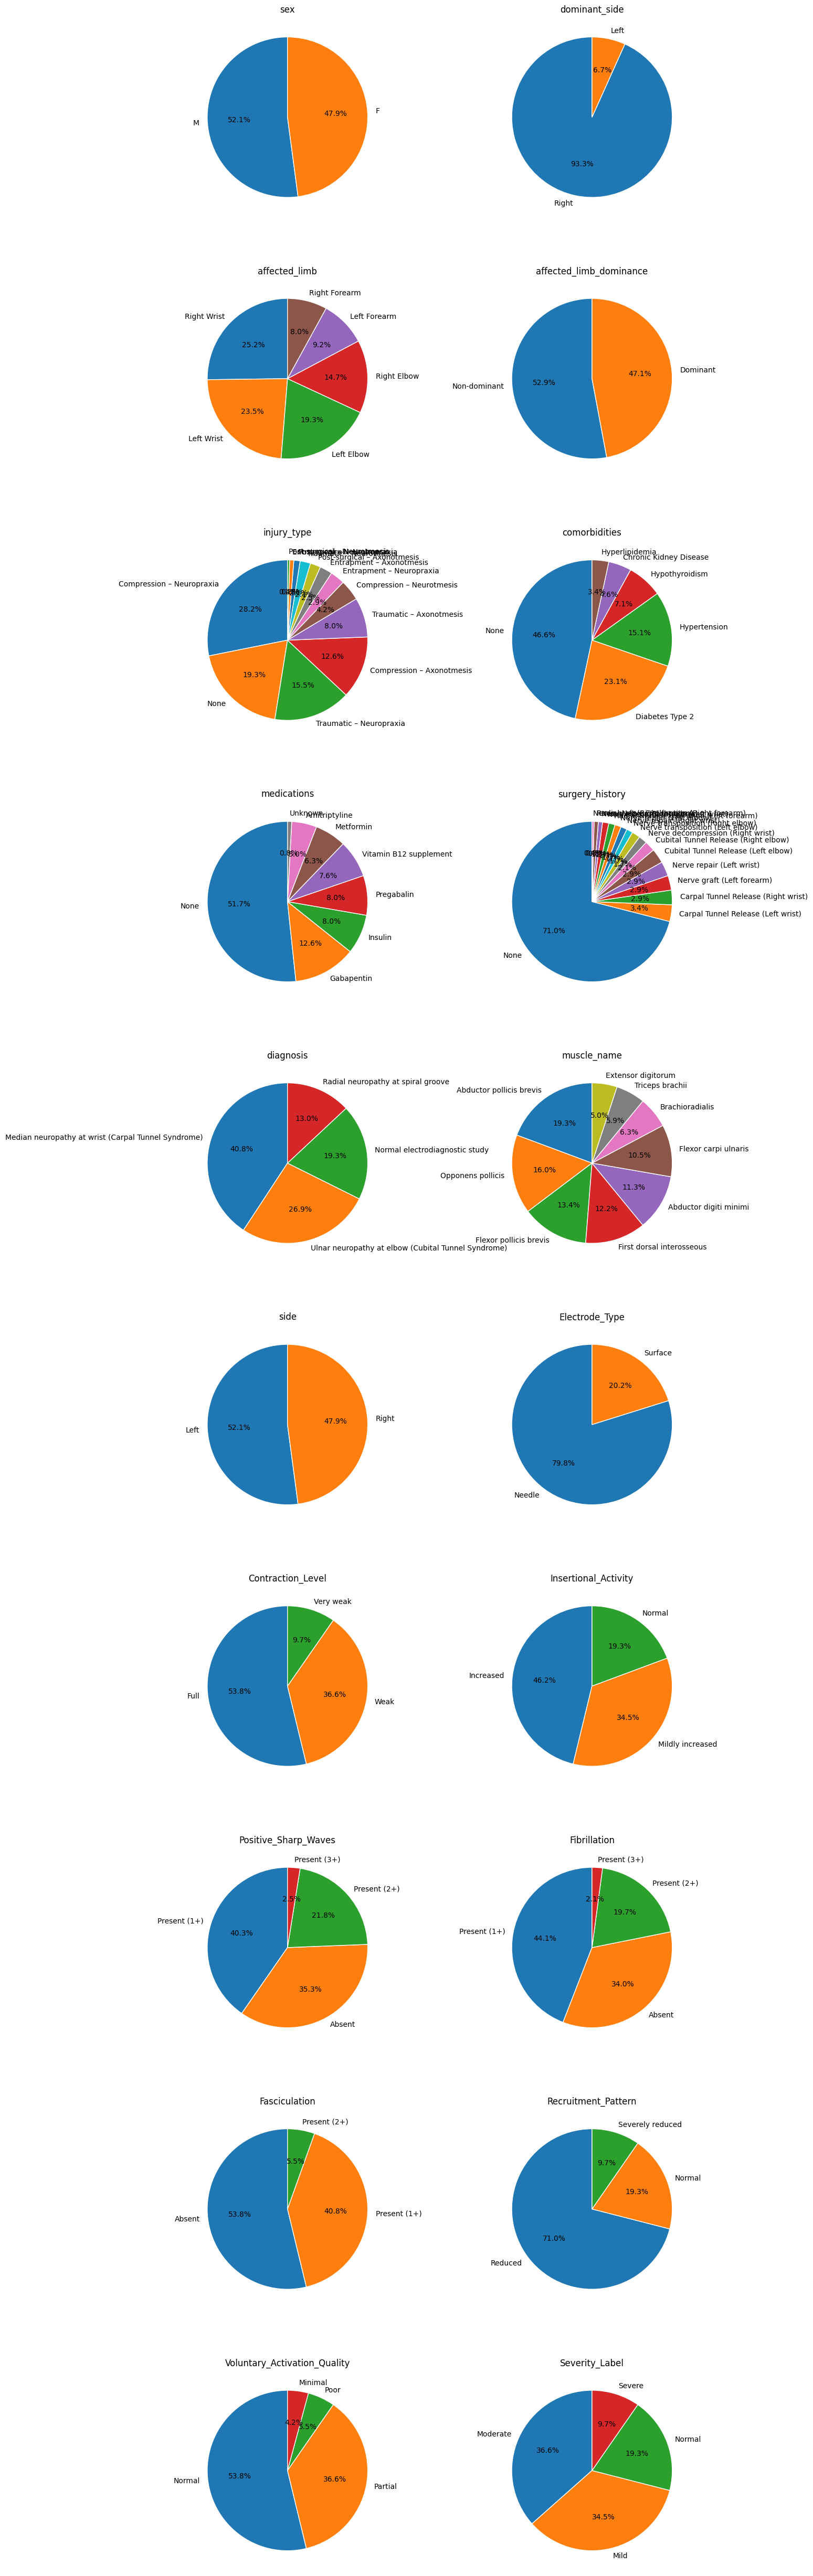

In [ ]:
# Pie chart

# Select categorical columns
categorical_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

# Number of categorical features
n_cat = len(categorical_cols)

# Subplot layout
cols = 2
rows = math.ceil(n_cat / cols)

# Create the figure
plt.figure(figsize=(14, rows * 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)

    # Get counts
    data = EMG_df[col].value_counts()

    # Pie chart
    plt.pie(
        data.values,
        labels=data.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )

    plt.title(f'{col}', fontsize=12)

plt.tight_layout()
plt.show()


## Missing Values

In [ ]:
print("Missing values per column:\n", EMG_df.isnull().sum()) #Nan None


Missing values per column:
 ID                                  0
age                                 0
sex                                 0
BMI                                 0
dominant_side                       0
affected_limb                       0
limb_temperature_c                  1
affected_limb_dominance             0
injury_type                         0
time_since_injury_months            3
comorbidities                       0
medications                         0
surgery_history                     0
diagnosis                           0
muscle_name                         0
side                                0
Electrode_Type                      0
Electrode_Depth                     1
Contraction_Level                   0
Insertional_Activity                0
Positive_Sharp_Waves                0
Fibrillation                        0
Fasciculation                       0
MUAP_Amplitude (mV)                 0
MUAP_Duration (ms)                  0
Recruitment_Pattern   

In [ ]:
# Missing values percentage per column
missing_percent = (EMG_df.isnull().sum() / len(EMG_df)) * 100

print("Missing Values Percentage (%):\n")
print(missing_percent.sort_values(ascending=False))

Missing Values Percentage (%):

time_since_injury_months            1.260504
limb_temperature_c                  0.420168
Electrode_Depth                     0.420168
sex                                 0.000000
BMI                                 0.000000
dominant_side                       0.000000
affected_limb                       0.000000
ID                                  0.000000
affected_limb_dominance             0.000000
injury_type                         0.000000
comorbidities                       0.000000
medications                         0.000000
surgery_history                     0.000000
diagnosis                           0.000000
muscle_name                         0.000000
age                                 0.000000
side                                0.000000
Electrode_Type                      0.000000
Contraction_Level                   0.000000
Insertional_Activity                0.000000
Positive_Sharp_Waves                0.000000
Fibrillation           

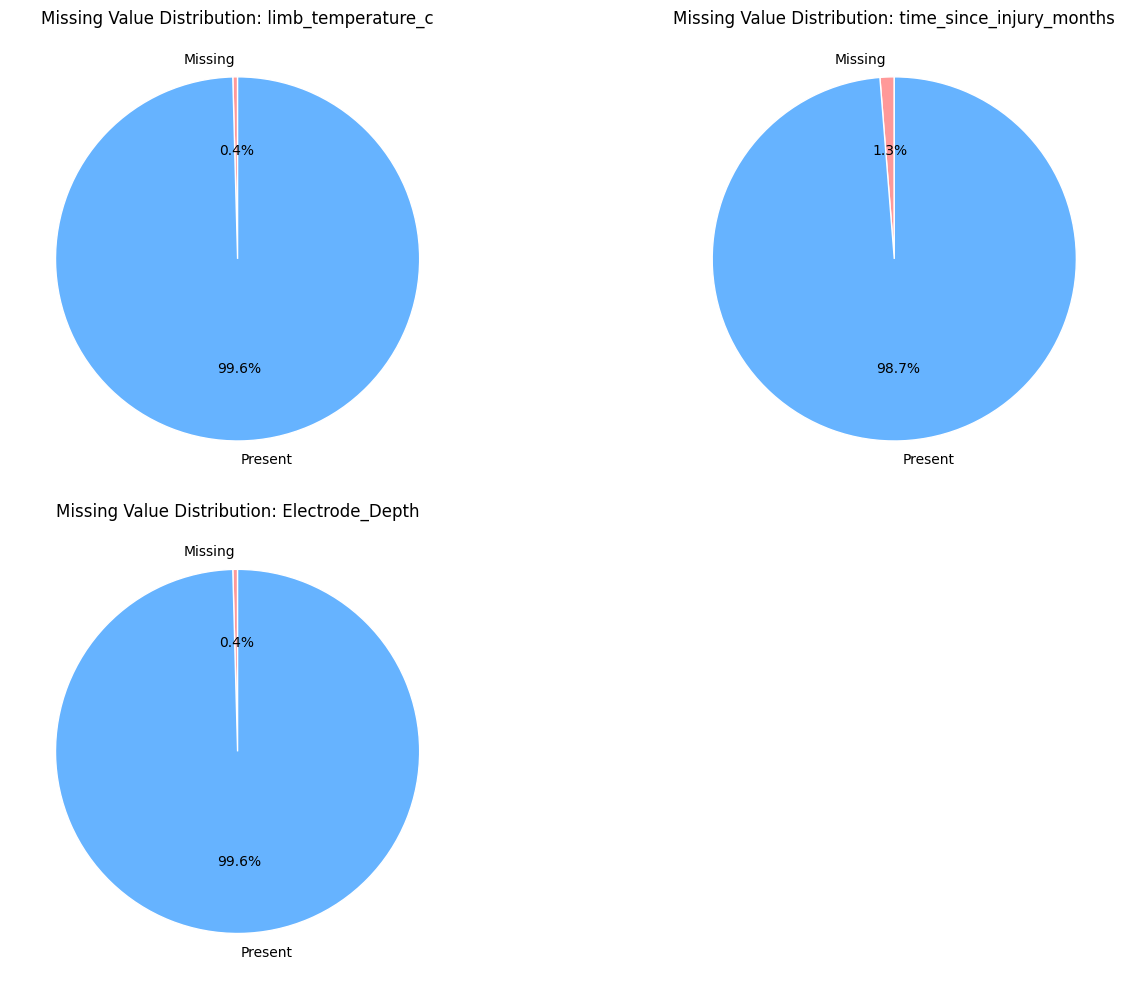

In [ ]:
#  Pie chart for Missing Values

# 1) Missing values percentage per column
missing_percent = (EMG_df.isnull().sum() / len(EMG_df)) * 100

# 2) Select only features that actually have missing values
missing_features = missing_percent[missing_percent > 0]


# 3) Subplot layout
n_features = len(missing_features)
cols = 2
rows = math.ceil(n_features / cols)

# 4) Create figure
plt.figure(figsize=(14, rows * 5))

# 5) Loop & draw pie chart for each feature
for i, col in enumerate(missing_features.index, 1):
    plt.subplot(rows, cols, i)

    # Values: missing vs present
    missing_count = EMG_df[col].isnull().sum()
    present_count = len(EMG_df) - missing_count

    plt.pie(
        [missing_count, present_count],
        labels=['Missing', 'Present'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999', '#66b3ff'],
        textprops={'fontsize': 10},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )

    plt.title(f'Missing Value Distribution: {col}', fontsize=12)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

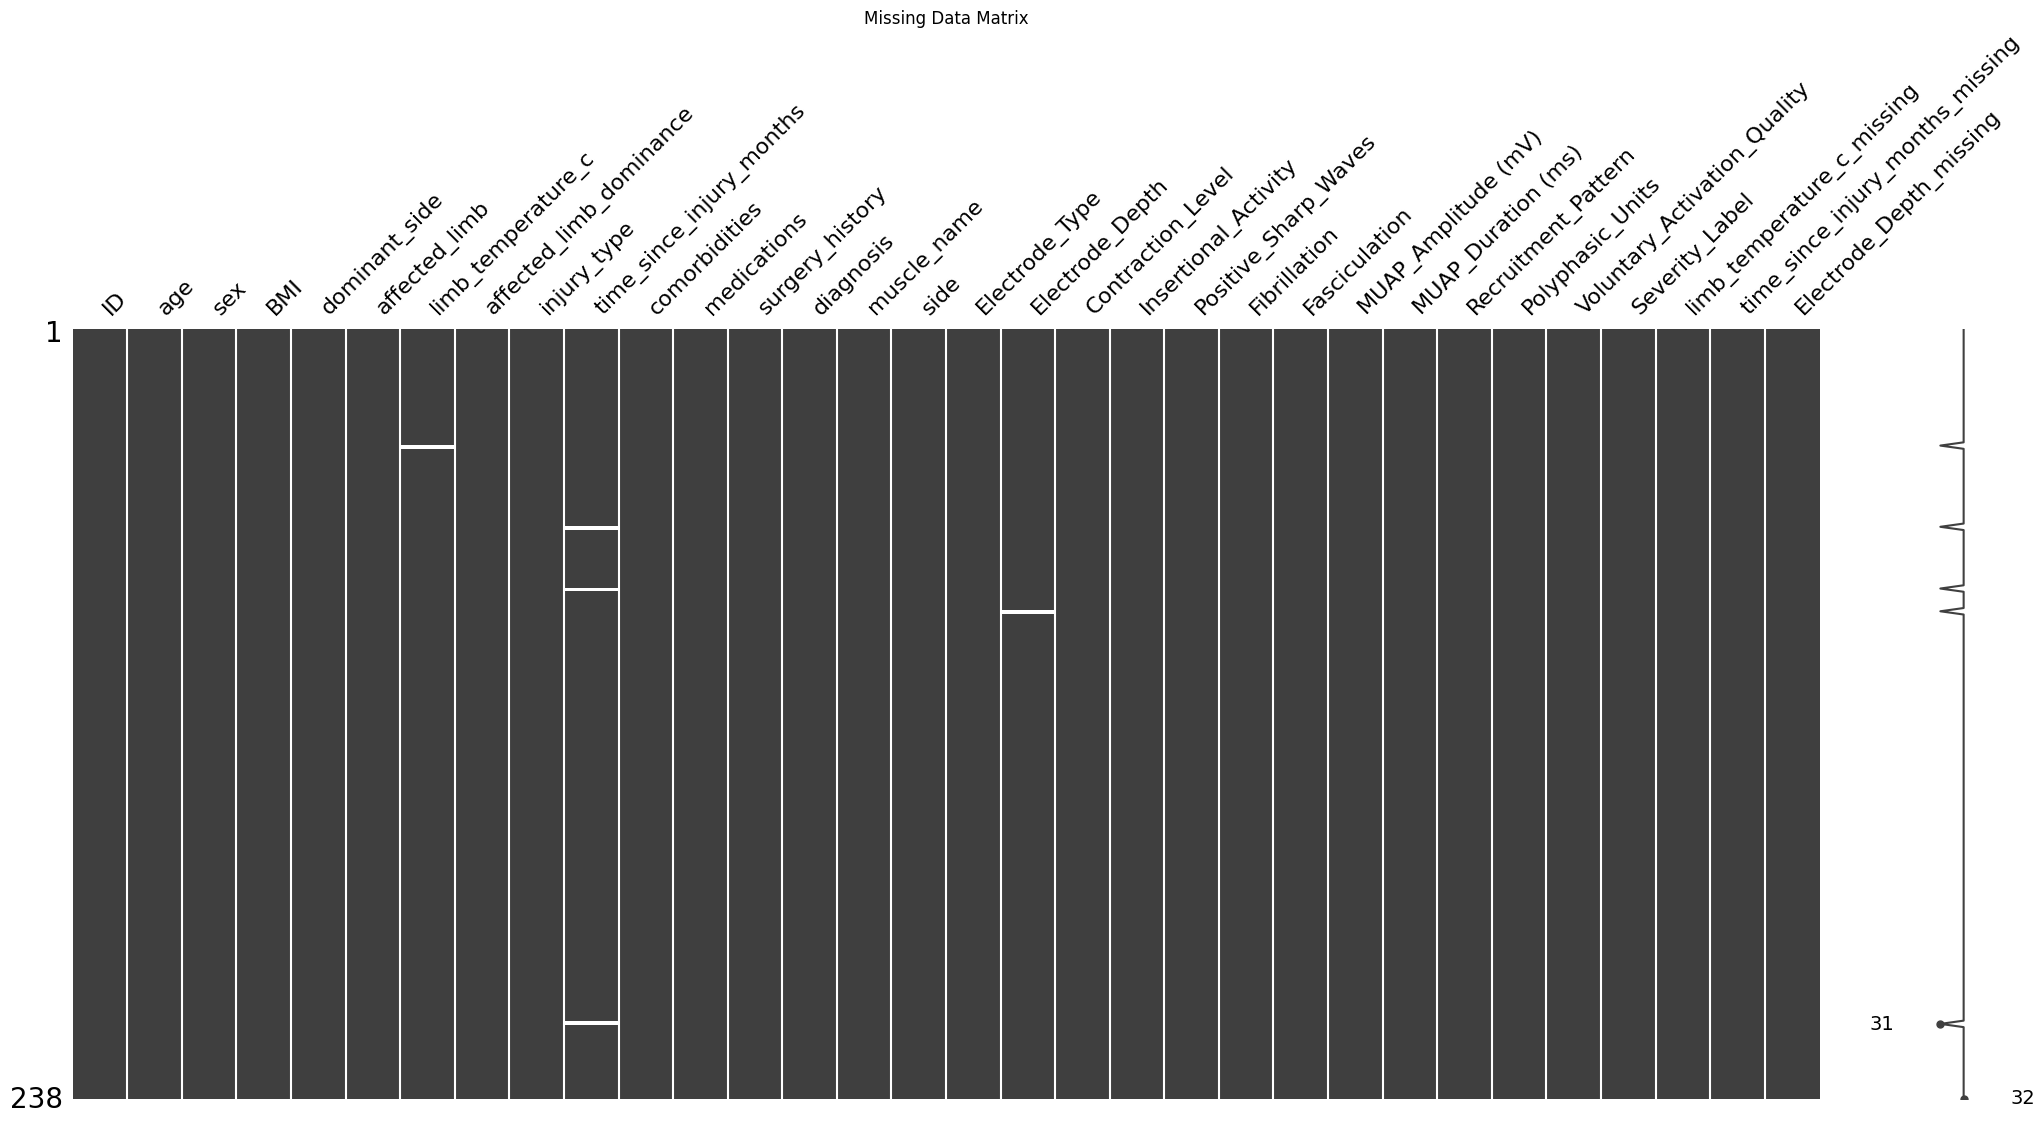

In [ ]:
# Missingno

plt.figure(figsize=(12, 6))
msno.matrix(EMG_df)
plt.title("Missing Data Matrix")
plt.show()


## Duplicates Recoreds


In [ ]:
dup_rows = EMG_df.duplicated().sum()
print("\nNumber of Fully Duplicated rows:", dup_rows)


Number of Fully Duplicated rows: 0


## Detecting Messy Format

In [ ]:
# Detect Non-Numeric Characters Inside Numeric Columns

for col in EMG_df.select_dtypes(include='object'):
    # Check if column is supposed to be numeric
    try:
        EMG_df[col].astype(float)
        print(f"POSSIBLE WRONG FORMAT → {col}: contains numeric-like strings")
    except:
        pass


In [ ]:
# Detect Leading / Trailing Spaces

for col in EMG_df.select_dtypes(include='object'):
    EMG_df[col] = EMG_df[col].astype(str)
    if EMG_df[col].str.contains(r'^\s+|\s+$').any():
        print(f"WARNING: Spaces in {col}")


In [ ]:
# Detect Mixed Formats

for col in EMG_df.select_dtypes(include='object'):
    print(f"\nUnique values in {col}:")
    print(EMG_df[col].unique())



Unique values in sex:
['M' 'F']

Unique values in dominant_side:
['Right' 'Left']

Unique values in affected_limb:
['Left Elbow' 'Left Wrist' 'Right Wrist' 'Right Forearm' 'Right Elbow'
 'Left Forearm']

Unique values in affected_limb_dominance:
['Non-dominant' 'Dominant']

Unique values in injury_type:
['Compression – Neuropraxia' 'Traumatic – Neuropraxia'
 'Entrapment – Neurotmesis' 'Traumatic – Axonotmesis'
 'Post-surgical – Neuropraxia' 'Post-surgical – Axonotmesis' 'None'
 'Post-surgical – Neurotmesis' 'Compression – Neurotmesis'
 'Compression – Axonotmesis' 'Entrapment – Neuropraxia'
 'Entrapment – Axonotmesis' 'Traumatic – Neurotmesis']

Unique values in comorbidities:
['None' 'Hypertension' 'Diabetes Type 2' 'Hypothyroidism'
 'Chronic Kidney Disease' 'Hyperlipidemia']

Unique values in medications:
['None' 'Pregabalin' 'Vitamin B12 supplement' 'Insulin' 'Metformin'
 'Unknown' 'Gabapentin' 'Amitriptyline']

Unique values in surgery_history:
['None' 'Carpal Tunnel Release (Left 

In [ ]:
# Detect Unexpected / Invalid Categories

for col in EMG_df.select_dtypes(include='object'):
    print(f"\n{col} → unique values:")
    print(EMG_df[col].value_counts(dropna=False))



sex → unique values:
sex
M    124
F    114
Name: count, dtype: int64

dominant_side → unique values:
dominant_side
Right    222
Left      16
Name: count, dtype: int64

affected_limb → unique values:
affected_limb
Right Wrist      60
Left Wrist       56
Left Elbow       46
Right Elbow      35
Left Forearm     22
Right Forearm    19
Name: count, dtype: int64

affected_limb_dominance → unique values:
affected_limb_dominance
Non-dominant    126
Dominant        112
Name: count, dtype: int64

injury_type → unique values:
injury_type
Compression – Neuropraxia      67
None                           46
Traumatic – Neuropraxia        37
Compression – Axonotmesis      30
Traumatic – Axonotmesis        19
Compression – Neurotmesis      10
Entrapment – Neuropraxia        7
Entrapment – Axonotmesis        6
Post-surgical – Axonotmesis     5
Traumatic – Neurotmesis         5
Post-surgical – Neuropraxia     3
Entrapment – Neurotmesis        2
Post-surgical – Neurotmesis     1
Name: count, dtype: int6

In [ ]:
# Detect Columns with Mixed Types

for col in EMG_df.columns:
    types = EMG_df[col].apply(type).value_counts()
    if len(types) > 1:
        print(f"Mixed types in {col}: {types}")


In [ ]:
# Detect Out-of-range Values (Medical Logic Rules)

print((EMG_df["age"] < 0).sum(), "negative ages")
print((EMG_df["limb_temperature_c"] > 45).sum(), "invalid temperatures")
print((EMG_df["MUAP_Amplitude (mV)"] < 0).sum(), "negative EMG amplitude")


0 negative ages
0 invalid temperatures
0 negative EMG amplitude


In [ ]:
# Detect Symbols or Patterns in Categorical Columns

import re

for col in EMG_df.select_dtypes(include='object'):
    if EMG_df[col].str.contains(r'\(|\)|\+|\-').any():
        print(f"Possible encoded scale in {col}")


Possible encoded scale in affected_limb_dominance
Possible encoded scale in injury_type
Possible encoded scale in surgery_history
Possible encoded scale in diagnosis
Possible encoded scale in Positive_Sharp_Waves
Possible encoded scale in Fibrillation
Possible encoded scale in Fasciculation


## Detecting Outliers



### IQR

In [ ]:
'''
  - Fourmla:
        IQR = Q3 − Q1
        [Q1−1.5× IQR , Q3+1.5×IQR]
'''

Q1 = EMG_df[numeric_cols].quantile(0.25)
Q3 = EMG_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean mask of outliers (True = outlier)
outlier_mask = (EMG_df[numeric_cols] < lower_bound) | (EMG_df[numeric_cols] > upper_bound)

# Number of rows with at least one outlier
print("IQR Outlier Rows:", outlier_mask.any(axis=1).sum())

# List rows + feature names
for idx in outlier_mask.any(axis=1).index[outlier_mask.any(axis=1)]:
    feats = list(outlier_mask.columns[outlier_mask.loc[idx]])
    print(f"Row {idx}: {feats}")


IQR Outlier Rows: 21
Row 27: ['time_since_injury_months']
Row 40: ['limb_temperature_c']
Row 49: ['BMI']
Row 52: ['time_since_injury_months']
Row 74: ['MUAP_Duration (ms)']
Row 83: ['limb_temperature_c']
Row 96: ['MUAP_Duration (ms)']
Row 104: ['limb_temperature_c']
Row 131: ['MUAP_Duration (ms)']
Row 143: ['time_since_injury_months']
Row 152: ['limb_temperature_c']
Row 163: ['MUAP_Amplitude (mV)']
Row 164: ['limb_temperature_c']
Row 177: ['age']
Row 180: ['limb_temperature_c']
Row 187: ['limb_temperature_c']
Row 192: ['limb_temperature_c']
Row 196: ['limb_temperature_c']
Row 197: ['limb_temperature_c']
Row 198: ['limb_temperature_c']
Row 228: ['limb_temperature_c']


### MAD:  Median Absolute Deviation




In [ ]:
'''
  MAD: Median Absolute Deviation (Robust Z-score)

  Why MAD?
  - Z-score uses mean and std → very sensitive to outliers
  - MAD uses median → resistant to extreme values

  - formula:
       Z_robust = 0.6745 * (x - median) / MAD

  - Outlier If:
       |Z_robust| > threshold

  - Common threshold = 3.5 (more robust than Z-score=3)
'''

threshold = 3.5

# Compute median and MAD per numeric feature
median_vals = EMG_df[numeric_cols].median()
mad_vals = EMG_df[numeric_cols].apply(median_abs_deviation)

# Smoothing: Avoid division by zero by replacing MAD=0 with a tiny value
mad_vals = mad_vals.replace(0, 1e-9)

# Compute Robust Z-score
df_mad = 0.6745 * (EMG_df[numeric_cols] - median_vals) / mad_vals

# Boolean mask of outliers
outlier_flags = df_mad.abs() > threshold

# Count outliers per row
outlier_mask = outlier_flags.sum(axis=1)


# Results
print(f"Rows with > {threshold} MAD deviations:", (outlier_mask > 0).sum())
print("\n=== Outlier Rows and Feature Names ===\n")

for idx, count in outlier_mask[outlier_mask > 0].items():
    features_with_outliers = list(outlier_flags.columns[outlier_flags.loc[idx]])
    print(f"Row {idx}: {features_with_outliers}")


Rows with > 3.5 MAD deviations: 2

=== Outlier Rows and Feature Names ===

Row 74: ['MUAP_Duration (ms)']
Row 131: ['MUAP_Duration (ms)']


### Z-Score

In [ ]:
'''
  in Gaussian Normal Distribution:
  - 68% of data  within   +-1 std
  - 95% is within         +- 2 std
  - 99.7% is within       += 3 std   ;  Anything beyond ±3 std is Outli

'''
#  Z-score threshold
std = 2

# Compute Z-scores only for numeric columns
df_z = EMG_df[numeric_cols].apply(zscore)


# Find outliers per row (True/False mask)
outlier_flags = df_z.abs() > std


# Count number of outliers per row
outlier_mask = outlier_flags.sum(axis=1)

# results
print("Rows with >",std," Standard Deviations:  ", (outlier_mask > 0).sum())
print("\n=== Outlier Rows and Feature Names ===\n")
for idx, count in outlier_mask[outlier_mask > 0].items():
    features_with_outliers = list(outlier_flags.columns[outlier_flags.loc[idx]])
    print(f"Row {idx}: {features_with_outliers}")

Rows with > 2  Standard Deviations:   39

=== Outlier Rows and Feature Names ===

Row 2: ['BMI', 'MUAP_Duration (ms)']
Row 9: ['BMI']
Row 13: ['MUAP_Amplitude (mV)']
Row 18: ['age']
Row 25: ['BMI']
Row 32: ['age']
Row 36: ['Polyphasic_Units']
Row 49: ['BMI']
Row 59: ['Polyphasic_Units']
Row 64: ['MUAP_Amplitude (mV)']
Row 66: ['BMI']
Row 73: ['MUAP_Amplitude (mV)']
Row 74: ['MUAP_Duration (ms)']
Row 81: ['Polyphasic_Units']
Row 96: ['MUAP_Duration (ms)']
Row 111: ['MUAP_Amplitude (mV)']
Row 124: ['age']
Row 131: ['MUAP_Duration (ms)']
Row 133: ['age']
Row 137: ['Polyphasic_Units']
Row 143: ['age']
Row 148: ['MUAP_Duration (ms)']
Row 162: ['MUAP_Duration (ms)']
Row 163: ['MUAP_Amplitude (mV)']
Row 170: ['age']
Row 172: ['MUAP_Duration (ms)']
Row 177: ['age']
Row 191: ['MUAP_Amplitude (mV)', 'Polyphasic_Units']
Row 194: ['BMI']
Row 202: ['Polyphasic_Units']
Row 204: ['BMI']
Row 211: ['BMI', 'MUAP_Amplitude (mV)']
Row 214: ['age']
Row 216: ['age']
Row 224: ['age']
Row 231: ['age']
Row 232

# Preprocessing

## Handle Missing Values (Unknown → NaN, Missing Indicators, Imputation)

In [ ]:
for col in numeric_fix_cols:
    median_val = EMG_df[col].median()
    EMG_df[col].fillna(median_val, inplace=True)


/tmp/ipython-input-2884066565.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  EMG_df[col].fillna(median_val, inplace=True)


In [ ]:
print("Missing values per column:\n", EMG_df.isnull().sum()) #Nan None


Missing values per column:
 ID                                  0
age                                 0
sex                                 0
BMI                                 0
dominant_side                       0
affected_limb                       0
limb_temperature_c                  0
affected_limb_dominance             0
injury_type                         0
time_since_injury_months            0
comorbidities                       0
medications                         0
surgery_history                     0
diagnosis                           0
muscle_name                         0
side                                0
Electrode_Type                      0
Electrode_Depth                     0
Contraction_Level                   0
Insertional_Activity                0
Positive_Sharp_Waves                0
Fibrillation                        0
Fasciculation                       0
MUAP_Amplitude (mV)                 0
MUAP_Duration (ms)                  0
Recruitment_Pattern   

In [ ]:
# Target columns
target_cols = ['Severity_Label']

# Reorder: (all other columns) + (target columns)
EMG_df = EMG_df[[col for col in EMG_df.columns if col not in target_cols] + target_cols]

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

EMG_df.head()

ID  age sex   BMI dominant_side affected_limb  limb_temperature_c  \
0   1   42   M  26.9         Right    Left Elbow                37.0   
1   2   41   F  33.7         Right    Left Wrist                35.8   
2   3   24   M  37.1         Right   Right Wrist                35.7   
3   4   52   M  26.4         Right   Right Wrist                36.0   
4   5   47   M  25.9         Right   Right Wrist                35.7   

  affected_limb_dominance                injury_type  \
0            Non-dominant  Compression – Neuropraxia   
1            Non-dominant    Traumatic – Neuropraxia   
2                Dominant   Entrapment – Neurotmesis   
3                Dominant  Compression – Neuropraxia   
4                Dominant    Traumatic – Axonotmesis   

   time_since_injury_months    comorbidities             medications  \
0                       1.0             None                    None   
1                       5.0     Hypertension              Pregabalin   
2                      10.0  Diabetes Type 2  Vitamin B12 supplement   
3                       6.0  Diabetes Type 2                 Insulin   
4                      10.0             None              Pregabalin   

                      surgery_history  \
0                                None   
1  Carpal Tunnel Release (Left wrist)   
2                                None   
3                                None   
4                                None   

                                             diagnosis  \
0  Ulnar neuropathy at elbow (Cubital Tunnel Syndrome)   
1  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
2  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
3  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
4  Median neuropathy at wrist (Carpal Tunnel Syndrome)   

                muscle_name   side Electrode_Type  Electrode_Depth  \
0      Flexor carpi ulnaris   Left         Needle              1.6   
1  Abductor pollicis brevis   Left         Needle              2.4   
2  Abductor pollicis brevis  Right         Needle              2.5   
3         Opponens pollicis  Right         Needle              1.0   
4  Abductor pollicis brevis  Right        Surface              0.5   

  Contraction_Level Insertional_Activity Positive_Sharp_Waves  Fibrillation  \
0              Weak            Increased         Present (2+)  Present (1+)   
1              Full     Mildly increased         Present (1+)  Present (1+)   
2         Very weak            Increased         Present (2+)  Present (1+)   
3              Weak            Increased         Present (1+)  Present (1+)   
4         Very weak            Increased         Present (1+)  Present (3+)   

  Fasciculation  MUAP_Amplitude (mV)  MUAP_Duration (ms) Recruitment_Pattern  \
0  Present (1+)                  3.3                 9.1             Reduced   
1        Absent                  5.2                 9.2             Reduced   
2  Present (1+)                  1.9                14.2    Severely reduced   
3  Present (1+)                  3.7                10.9             Reduced   
4  Present (2+)                  1.5                 9.0    Severely reduced   

   Polyphasic_Units Voluntary_Activation_Quality  limb_temperature_c_missing  \
0                43                      Partial                       False   
1                23                       Normal                       False   
2                61                      Minimal                       False   
3                41                      Partial                       False   
4                35                      Minimal                       False   

   time_since_injury_months_missing  Electrode_Depth_missing Severity_Label  
0                             False                    False       Moderate  
1                             False                    False           Mild  
2                             False                    False         Severe  
3                             Fals

##Drop Non-Informative Columns




In [ ]:
drop_cols = [
    'ID',
    'comorbidities',
    'medications',
    'surgery_history',
    'diagnosis'

]
EMG_df = EMG_df.drop(columns=drop_cols)


##categorical encoding






### Label Encoding (Binary Encoding)


In [ ]:
'''
binary_mappings = {
    'sex': {'M': 1, 'F': 0},
    'affected_limb_dominance': {'Dominant': 1, 'Non-dominant': 0},
    'side': {'Right': 1, 'Left': 0},
    'Electrode_Type': {'Needle': 1, 'Surface': 0},
    'dominant_side':{'Right': 1, 'Left': 0},
}

for col, mapping in binary_mappings.items():
    EMG_df[col] = EMG_df[col].map(mapping)
'''

"\nbinary_mappings = {\n    'sex': {'M': 1, 'F': 0},\n    'affected_limb_dominance': {'Dominant': 1, 'Non-dominant': 0},\n    'side': {'Right': 1, 'Left': 0},\n    'Electrode_Type': {'Needle': 1, 'Surface': 0},\n    'dominant_side':{'Right': 1, 'Left': 0},\n}\n\nfor col, mapping in binary_mappings.items():\n    EMG_df[col] = EMG_df[col].map(mapping)\n"

In [ ]:
print(EMG_df.columns)

Index(['age', 'sex', 'BMI', 'dominant_side', 'affected_limb',
       'limb_temperature_c', 'affected_limb_dominance', 'injury_type',
       'time_since_injury_months', 'muscle_name', 'side', 'Electrode_Type',
       'Electrode_Depth', 'Contraction_Level', 'Insertional_Activity',
       'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation',
       'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Recruitment_Pattern',
       'Polyphasic_Units', 'Voluntary_Activation_Quality',
       'limb_temperature_c_missing', 'time_since_injury_months_missing',
       'Electrode_Depth_missing', 'Severity_Label'],
      dtype='object')


### Ordinal Encoding For The Label

In [ ]:
# Encode target once (before splitting is fine)
severity_map = {
    'Normal'  : 0,
    'Mild'    : 1,
    'Moderate': 2,
    'Severe'  : 3
}
EMG_df['Severity_Label'] = EMG_df['Severity_Label'].map(severity_map).astype(int)


In [ ]:
## Feature Encoding: Ordinal Mapping (BEST -> WORST order)

# Define fixed order for ALL ordinal features
ordinal_maps = {

    'Contraction_Level': {
        'Full': 0,
        'Weak': 1,
        'Very weak': 2,
    },
    'Recruitment_Pattern': {
        'Normal': 0,
        'Reduced': 1,
        'Severely reduced': 2
    },
    'Voluntary_Activation_Quality': {
        'Normal': 0,
        'Partial': 1,
        'Minimal': 2,
        'Poor': 3
    },


    'Insertional_Activity': {
        'Normal': 0,
        'Mildly increased': 1,
        'Increased': 2
    },
    'Fasciculation': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2
    },
    'Positive_Sharp_Waves': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2,
        'Present (3+)': 3
    },
    'Fibrillation': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2,
        'Present (3+)': 3
    }
}

In [ ]:
# Apply Ordinal Encoding

for col, mapping in ordinal_maps.items():
    # Use .map() to apply the dictionary and .astype(int) to ensure integer type
    EMG_df[col] = EMG_df[col].map(mapping).astype(int)

print("All Ordinal features, including severity grades, are now correctly encoded.")

All Ordinal features, including severity grades, are now correctly encoded.


#----------------- Modelling---------------------

# CatBoost Classifier - Preperation

In [ ]:
# Data Info

EMG_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   age                               238 non-null    int64  
 1   sex                               238 non-null    object 
 2   BMI                               238 non-null    float64
 3   dominant_side                     238 non-null    object 
 4   affected_limb                     238 non-null    object 
 5   limb_temperature_c                238 non-null    float64
 6   affected_limb_dominance           238 non-null    object 
 7   injury_type                       238 non-null    object 
 8   time_since_injury_months          238 non-null    float64
 9   muscle_name                       238 non-null    object 
 10  side                              238 non-null    object 
 11  Electrode_Type                    238 non-null    object 
 12  Electrod

In [ ]:
# Manully define Num col
numeric_cols = [
    'age',
    'BMI',
    'limb_temperature_c',
    'time_since_injury_months',
    'Electrode_Depth',
    'MUAP_Amplitude (mV)',
    'MUAP_Duration (ms)',
    'Polyphasic_Units',

     # Ordinal After Encoding
    'Contraction_Level',
    'Recruitment_Pattern',
    'Voluntary_Activation_Quality',
    'Insertional_Activity',
    'Fasciculation',
    'Positive_Sharp_Waves',
    'Fibrillation',

    # missing values indicatoe
    'limb_temperature_c_missing',
    'time_since_injury_months_missing',
    'Electrode_Depth_missing'
]

In [ ]:
# Manully define Cat col

cat_features = [
    'sex',
    'dominant_side',
    'affected_limb',
    'affected_limb_dominance',
    'injury_type',
    'muscle_name',
    'side',
    'Electrode_Type',
]


In [ ]:
# Split

X = EMG_df.drop("Severity_Label", axis=1)
y = EMG_df["Severity_Label"]


In [ ]:
print("EMG shape:", EMG_df.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)

EMG shape: (238, 27)
X shape: (238, 26)
y shape: (238,)


In [ ]:
base_params = {
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1',
    'auto_class_weights': 'Balanced',
    'depth': 5,
    'learning_rate': 0.05,
    'iterations': 300,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'rsm': 0.8,
    'random_strength': 1,
    'od_type': 'Iter',
    'od_wait': 30,
    'random_seed': 42,
    'verbose': 50,
    'l2_leaf_reg': 3
}


# Fisher score ( With Leakage )

In [ ]:
# === Prepare X and y ===

X = EMG_df.drop("Severity_Label", axis=1)
y = EMG_df["Severity_Label"]

print( numeric_cols )
print( cat_features )

['age', 'BMI', 'limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units', 'Contraction_Level', 'Recruitment_Pattern', 'Voluntary_Activation_Quality', 'Insertional_Activity', 'Fasciculation', 'Positive_Sharp_Waves', 'Fibrillation', 'limb_temperature_c_missing', 'time_since_injury_months_missing', 'Electrode_Depth_missing']
['sex', 'dominant_side', 'affected_limb', 'affected_limb_dominance', 'injury_type', 'muscle_name', 'side', 'Electrode_Type']


In [ ]:
n_features = X.shape[1]
print("Number of features:", n_features)

severe_label = 3

k_values = [None, 3, 5, 8, 10, 12, 15, 20, 23]

Number of features: 26


In [ ]:
def fisher_score_custom(X, y):
    """
    X : np.ndarray  (n_samples, n_features)
    y : np.ndarray  (n_samples,)
    Returns: Fisher score for each feature (length = n_features)
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    classes = np.unique(y)
    n_samples, n_features = X.shape

    overall_mean = X.mean(axis=0)

    numerator = np.zeros(n_features)
    denominator = np.zeros(n_features)

    for c in classes:
        idx = (y == c)
        X_c = X[idx]
        n_c = X_c.shape[0]

        if n_c == 0:
            continue

        mean_c = X_c.mean(axis=0)
        var_c  = X_c.var(axis=0)

        numerator   += n_c * (mean_c - overall_mean) ** 2
        denominator += n_c * var_c


    scores = numerator / (denominator + 1e-8)
    return scores


In [ ]:
results = []   # to store mean metrics for each k

classes = np.sort(y.unique())

for k in k_values:
    print("\n" + "="*60)
    if k is None or k >= n_features:
        print("Running CV with: ALL FEATURES (no Fisher Score)")
        use_fisher = False
        k_display = "all"
    else:
        print(f"Running CV with Fisher Score, top {k} features")
        use_fisher = True
        k_display = k

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracies_ = []
    macro_f1s  = []
    mccs       = []
    ap_severe_list = []


   # will store the feature names chosen for this k (once)
    selected_features_for_k = None

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        # --- Split fold ---
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        '''
        # --- Frequency Encoding (TRAIN only, then apply to TEST) ---
        for col in freq_cols:
            freq = X_train[col].value_counts(normalize=True)
            X_train[col] = X_train[col].map(freq)
            X_test[col]  = X_test[col].map(freq).fillna(0)
        '''

        # --- Fisher Score feature selection ---
        if use_fisher:
          # Only Nums cols
          numeric_in_fold = [c for c in numeric_cols if c in X_train.columns]

          scores = fisher_score_custom(
             X_train[numeric_in_fold].values,
             y_train.values
          )

          k_eff = min(k, len(numeric_in_fold))
          idx = np.argsort(scores)[::-1][:k_eff]
          selected_features = np.array(numeric_in_fold)[idx]

          if selected_features_for_k is None:
             selected_features_for_k = list(selected_features)

          X_train_fs = X_train[selected_features]
          X_test_fs  = X_test[selected_features]

        else:
          X_train_fs = X_train
          X_test_fs  = X_test


        # --- Model ---
        cat_idx = [
            i for i, col in enumerate(X_train_fs.columns)
            if col in cat_features
        ]

        model =  CatBoostClassifier(**base_params)
        model.fit(
            X_train_fs,
            y_train,
            cat_features= cat_idx,
            verbose=False
         )


        # --- Predict ---
        y_pred = model.predict(X_test_fs)
        y_pred = y_pred.astype(int).ravel()

        y_proba = model.predict_proba(X_test_fs)




        # --- Metrics ---
        acc      = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        mcc      = matthews_corrcoef(y_test, y_pred)

        # AUC-PR (Average Precision) for Severe vs rest
        y_test_severe = (y_test == severe_label).astype(int)
        severe_index  = np.where(model.classes_ == severe_label)[0][0]
        severe_probs  = y_proba[:, severe_index]
        ap_severe     = average_precision_score(y_test_severe, severe_probs)

        accuracies_.append(acc)
        macro_f1s.append(macro_f1)
        mccs.append(mcc)
        ap_severe_list.append(ap_severe)

        print(f"Fold {fold} - Acc: {acc:.3f}, Macro F1: {macro_f1:.3f}, MCC: {mcc:.3f}, AP_severe: {ap_severe:.3f}")

    # === store mean metrics for this k ===
    result_row = {
        "k": k_display,
        "mean_accuracy": np.mean(accuracies_),
        "mean_macro_f1": np.mean(macro_f1s),
        "mean_MCC": np.mean(mccs),
        "mean_AP_severe": np.mean(ap_severe_list)
    }

     # add selected features info
    if use_fisher:
        result_row["selected_features"] = selected_features_for_k
        print("\nSelected features for k =", k_display)
        print(selected_features_for_k)
    else:
        result_row["selected_features"] = "all_features"


    results.append(result_row)
    print("\nSummary for k =", k_display)
    print(f"  Mean Accuracy      : {result_row['mean_accuracy'] * 100}%")
    print(f"  Mean Macro F1      : {result_row['mean_macro_f1'] * 100}%")
    print(f"  Mean MCC           : {result_row['mean_MCC']}")
    print(f"  Mean AP (Severe)   : {result_row['mean_AP_severe'] * 100}%")
    print(f"  Selected features  : {result_row['selected_features']}")


# === Convert results to DataFrame for easy comparison ===
results_df = pd.DataFrame(results)
print("\n\n=== All results ===")
print(results_df)



Running CV with: ALL FEATURES (no Fisher Score)
Fold 1 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 2 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 3 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 4 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 5 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000

Summary for k = all
  Mean Accuracy      : 100.0%
  Mean Macro F1      : 100.0%
  Mean MCC           : 1.0
  Mean AP (Severe)   : 100.0%
  Selected features  : all_features

Running CV with Fisher Score, top 3 features
Fold 1 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 2 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 3 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 4 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 5 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000

Selected features for k = 3
[np.str_('Insertional_Activity')

In [ ]:
for row in results:
    print("\n#### k =", row["k"], "####")
    print("Selected Features:")

    sf = row["selected_features"]
    if isinstance(sf, list):
        for f in sf:
            print(" -", f)
    else:
        print(sf)



#### k = all ####
Selected Features:
all_features

#### k = 3 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern

#### k = 5 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation

#### k = 8 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation

#### k = 10 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUAP_Amplitude (mV)
 - MUAP_Duration (ms)

#### k = 12 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUA

#Forward Selection (Sequential Forward Selection – SFS ) + Startified CV

##set Modelling Configuration

In [ ]:
# Define Features

print("Numaric Features: ", numeric_cols )
print("Catgorical Features: ",cat_features )

Numaric Features:  ['age', 'BMI', 'limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units', 'Contraction_Level', 'Recruitment_Pattern', 'Voluntary_Activation_Quality', 'Insertional_Activity', 'Fasciculation', 'Positive_Sharp_Waves', 'Fibrillation', 'limb_temperature_c_missing', 'time_since_injury_months_missing', 'Electrode_Depth_missing']
Catgorical Features:  ['sex', 'dominant_side', 'affected_limb', 'affected_limb_dominance', 'injury_type', 'muscle_name', 'side', 'Electrode_Type']


In [ ]:
leakage_features = [
    "Contraction_Level",
    "Insertional_Activity",
    "Recruitment_Pattern",
    "Voluntary_Activation_Quality"
]
# Drop Leakage

clean_numeric_cols = [col for col in numeric_cols if col not in leakage_features]
clean_cat_features = [col for col in cat_features if col not in leakage_features]


print("Numeric Features (before cleaning):", len(numeric_cols))
print("Numeric Features (after cleaning):", len(clean_numeric_cols))
print("Numeric Features (after cleaning):", clean_numeric_cols)

print("\n\nCategorical Features (before cleaning):", len(cat_features))
print("Categorical Features (after cleaning):", len(clean_cat_features))
print("Categorical Features (after cleaning):", clean_cat_features)

Numeric Features (before cleaning): 18
Numeric Features (after cleaning): 14
Numeric Features (after cleaning): ['age', 'BMI', 'limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units', 'Fasciculation', 'Positive_Sharp_Waves', 'Fibrillation', 'limb_temperature_c_missing', 'time_since_injury_months_missing', 'Electrode_Depth_missing']


Categorical Features (before cleaning): 8
Categorical Features (after cleaning): 8
Categorical Features (after cleaning): ['sex', 'dominant_side', 'affected_limb', 'affected_limb_dominance', 'injury_type', 'muscle_name', 'side', 'Electrode_Type']


In [ ]:
# Split

X = EMG_df.drop("Severity_Label", axis=1)
y = EMG_df["Severity_Label"]

print("EMG shape:", EMG_df.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)

EMG shape: (238, 27)
X shape: (238, 26)
y shape: (238,)


In [ ]:
# Drop leakage features ONLY if they exist in X

X = X.drop(columns=[f for f in leakage_features if f in X.columns])

print("X shape after conditional leakage drop:", X.shape)
print("Remaining columns in X:", X.columns.tolist())

X shape after conditional leakage drop: (238, 22)
Remaining columns in X: ['age', 'sex', 'BMI', 'dominant_side', 'affected_limb', 'limb_temperature_c', 'affected_limb_dominance', 'injury_type', 'time_since_injury_months', 'muscle_name', 'side', 'Electrode_Type', 'Electrode_Depth', 'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units', 'limb_temperature_c_missing', 'time_since_injury_months_missing', 'Electrode_Depth_missing']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        # 20% as final test set
    stratify=y,           # keep class distribution
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape,  y_test.shape)

Train: (190, 22) (190,)
Test : (48, 22) (48,)


##set SFS Configuration

In [ ]:
# All candidate features for selection (leak-free)
candidate_features = X_train.columns.tolist()


# Maximum number of features we want SFS to select
max_features = 8   # we can reduce to 5 or increase to 10 depending on time


#  Number of folds for Stratified K-Fold CV
k_folds = 5


'''
  - OPTIONAL: remove very low-variance / almost-constant features if you want
low_variance_feats = ['time_since_injury_months_missing',
                       'limb_temperature_c_missing',
                       'Electrode_Depth_missing']
candidate_features = [f for f in candidate_features if f not in low_variance_feats]
'''
candidate_features = X_train.columns.tolist()



print("Total candidate features:", len(candidate_features))
print("Candidate features:", candidate_features)

Total candidate features: 22
Candidate features: ['age', 'sex', 'BMI', 'dominant_side', 'affected_limb', 'limb_temperature_c', 'affected_limb_dominance', 'injury_type', 'time_since_injury_months', 'muscle_name', 'side', 'Electrode_Type', 'Electrode_Depth', 'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units', 'limb_temperature_c_missing', 'time_since_injury_months_missing', 'Electrode_Depth_missing']


In [ ]:
# Evaluate one feature subset using CV


def evaluate_feature_subset(feature_list):
    """
    Train CatBoost with Stratified K-Fold CV on a given subset of features.
    Return the mean Macro F1 score across folds.
    If CatBoost fails (e.g., all features constant or ignored in a fold),
    return a very low score so this subset is never selected.
    """

    # Select only the columns in the feature_list from X_train
    X_sub = X_train[feature_list]

    # Determine which of the selected features are categorical - (intersection with the known cat_features list)
    cat_feats_in_subset = [f for f in feature_list if f in clean_cat_features]




    # Initialize Stratified K-Fold object
    skf = StratifiedKFold(
        n_splits=k_folds,      # number of folds
        shuffle=True,          # shuffle before splitting
        random_state=42        # reproducibility
    )



    # Store F1 scores from each fold
    fold_f1s = []



    # Loop over folds
    for fold_idx, (tr_idx, val_idx) in enumerate(skf.split(X_sub, y_train), start=1):

        # Split into train and validation for this fold
        X_tr, X_val = X_sub.iloc[tr_idx], X_sub.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # Create a new CatBoost model with the baseline parameters
        model = CatBoostClassifier(**base_params)


        try:
            # Fit the model on this fold's training data
            model.fit(
                X_tr,
                y_tr,
                cat_features=cat_feats_in_subset,   # pass categorical features for CatBoost
                eval_set=(X_val, y_val),            # validation set for early stopping / monitoring
                use_best_model=True,                # keep the best iteration
                verbose=False                       # silent training for SFS
            )

        except CatBoostError as e:
            # If CatBoost fails (e.g., "all features constant or ignored"), print a warning and return a very low score for this subset.
            print(f"    [WARN] Failed on subset {feature_list} in fold {fold_idx}: {e}")
            return -1e6   # very bad score so SFS will never choose this subset

        # Predict class labels on the validation fold
        y_val_pred = model.predict(X_val).astype(int)

        # Compute Macro F1 for this fold
        fold_f1 = f1_score(y_val, y_val_pred, average="macro")

        # Save the fold F1
        fold_f1s.append(fold_f1)



    # Compute mean Macro F1 across folds
    mean_f1 = np.mean(fold_f1s)
    return mean_f1

##Sequential Forward Selection (SFS)

In [ ]:
from catboost import CatBoostError

# List of features selected so far (starts empty)
selected_features = []

# List of features that are not selected yet
remaining_features = candidate_features.copy()

# To store history of selection steps
sfs_history = []


# each step we add exactly one new feature
for step in range(1, max_features + 1):
    print(f"\n===== SFS STEP {step} =====")

    best_feat = None
    best_score = -1


    # Try adding each remaining feature and evaluate performance
    for feat in remaining_features:

        # Candidate subset = current selected features + this new feature
        trial_features = selected_features + [feat]

        # Evaluate this subset using Stratified CV + CatBoost
        mean_f1 = evaluate_feature_subset(trial_features)

        # Print the result for this candidate feature
        print(f"  Trying +{feat:30s} -> Mean Macro F1 = {mean_f1:.4f}")

        # If this is the best score so far in this step, remember it
        if mean_f1 > best_score:
            best_score = mean_f1
            best_feat = feat

    # After checking all remaining features, choose the best one for this step
    selected_features.append(best_feat)       # add best feature to selected list
    remaining_features.remove(best_feat)      # remove it from the remaining list

    # Print summary for this step
    print(f"\n***Selected feature at STEP {step}: {best_feat}")
    print(f"     Mean Macro F1 with this subset: {best_score:.4f}")
    print(f"     Current selected set: {selected_features}")

    # Save step information to history
    sfs_history.append({
        "step": step,
        "added_feature": best_feat,
        "mean_macro_f1": best_score,
        "selected_features": selected_features.copy()
    })


===== SFS STEP 1 =====
  Trying +age                            -> Mean Macro F1 = 0.3160
  Trying +sex                            -> Mean Macro F1 = 0.1372
  Trying +BMI                            -> Mean Macro F1 = 0.2431
  Trying +dominant_side                  -> Mean Macro F1 = 0.0513
  Trying +affected_limb                  -> Mean Macro F1 = 0.2422
  Trying +limb_temperature_c             -> Mean Macro F1 = 0.1966
  Trying +affected_limb_dominance        -> Mean Macro F1 = 0.2091
  Trying +injury_type                    -> Mean Macro F1 = 0.5803
  Trying +time_since_injury_months       -> Mean Macro F1 = 0.5531
  Trying +muscle_name                    -> Mean Macro F1 = 0.1914
  Trying +side                           -> Mean Macro F1 = 0.1160
  Trying +Electrode_Type                 -> Mean Macro F1 = 0.1414
  Trying +Electrode_Depth                -> Mean Macro F1 = 0.2149
  Trying +Positive_Sharp_Waves           -> Mean Macro F1 = 0.4820
  Trying +Fibrillation                

In [ ]:
#After loop ends, SFS is finished
print("\n===== FINAL SEQUENTIAL FORWARD SELECTION (SFS) RESULT =====\n\n")

print("Selected features in order:")
for entry in sfs_history:
    print(f"Step {entry['step']}: +{entry['added_feature']} (Mean F1 = {entry['mean_macro_f1']:.4f})")


===== FINAL SEQUENTIAL FORWARD SELECTION (SFS) RESULT =====


Selected features in order:
Step 1: +Polyphasic_Units (Mean F1 = 0.6508)
Step 2: +Fasciculation (Mean F1 = 0.8307)
Step 3: +Positive_Sharp_Waves (Mean F1 = 0.9125)
Step 4: +MUAP_Amplitude (mV) (Mean F1 = 0.9189)
Step 5: +injury_type (Mean F1 = 0.9515)
Step 6: +Electrode_Type (Mean F1 = 0.9532)
Step 7: +affected_limb (Mean F1 = 0.9720)
Step 8: +muscle_name (Mean F1 = 0.9683)


In [ ]:
# Final selected subset from SFS (you can use all or cut at best step)

selected_features_sfs = selected_features

print("\nFinal SFS-selected feature subset:")
print(selected_features_sfs)


Final SFS-selected feature subset:
['Polyphasic_Units', 'Fasciculation', 'Positive_Sharp_Waves', 'MUAP_Amplitude (mV)', 'injury_type', 'Electrode_Type', 'affected_limb', 'muscle_name']


# Main Loop (Forward) (Leak-Free)

In [ ]:
# ============================================
# SFS EVALUATION LOOP OVER DIFFERENT k VALUES
# ============================================

# How many top features (from SFS order) you want to evaluate
max_features_to_eval = 20   # you can change this (e.g., 5, 10, etc.)
k_values_sfs = list(range(1, max_features_to_eval + 1))

# This will store the mean metrics for each k
sfs_results = []

for k in k_values_sfs:
    # Take the first k features from the SFS-selected order
    feat_subset = selected_features_sfs[:k]

    print("\n" + "="*80)
    print(f"Method: SFS | k = {k}")
    print("Feature subset:", feat_subset)

    # 5-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # ---- TEST metrics (validation) ----
    accuracies_    = []
    macro_f1s      = []
    mccs           = []
    ap_severe_list = []

    # ---- TRAIN metrics (overfitting check) ----
    train_accuracies_ = []
    train_macro_f1s   = []
    train_mccs        = []

    # Loop over folds
    for fold, (train_idx, test_idx) in enumerate(skf.split(X[feat_subset], y), start=1):
        # Split data using the selected subset of features
        X_train_fs = X.iloc[train_idx][feat_subset].copy()
        X_test_fs  = X.iloc[test_idx][feat_subset].copy()
        y_train    = y.iloc[train_idx]
        y_test     = y.iloc[test_idx]

        # Categorical feature indices within this subset (for CatBoost)
        cat_idx_fs = [
            i for i, col in enumerate(feat_subset)
            if col in clean_cat_features
        ]

        # Define CatBoost model with your base parameters
        model = CatBoostClassifier(**base_params)
        model.fit(
            X_train_fs,
            y_train,
            cat_features=cat_idx_fs,
            verbose=False
        )

        # ==========================
        # TRAIN predictions & metrics
        # ==========================
        y_train_pred = model.predict(X_train_fs)

        train_acc      = accuracy_score(y_train, y_train_pred)
        train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
        train_mcc      = matthews_corrcoef(y_train, y_train_pred)

        train_accuracies_.append(train_acc)
        train_macro_f1s.append(train_macro_f1)
        train_mccs.append(train_mcc)

        # ==========================
        # TEST predictions & metrics
        # ==========================
        y_pred  = model.predict(X_test_fs)
        y_proba = model.predict_proba(X_test_fs)

        acc      = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        mcc      = matthews_corrcoef(y_test, y_pred)

        # Average Precision for the "severe" class
        y_test_severe = (y_test == severe_label).astype(int)
        severe_index  = np.where(model.classes_ == severe_label)[0][0]
        severe_probs  = y_proba[:, severe_index]
        ap_severe     = average_precision_score(y_test_severe, severe_probs)

        accuracies_.append(acc)
        macro_f1s.append(macro_f1)
        mccs.append(mcc)
        ap_severe_list.append(ap_severe)

        # Print fold-level metrics in your preferred percentage style
        print(
            f"Fold {fold} - "
            f"Train Acc: %{train_acc*100}, Test Acc: %{acc*100}, "
            f"Train Macro F1: %{train_macro_f1*100}, Test Macro F1: %{macro_f1*100}, "
            f"Train MCC: %{train_mcc*100}, Test MCC: {mcc*100}, "
            f"AP_severe (test): %{ap_severe*100}"
        )

    # After all folds, compute mean metrics for this k
    row = {
        "method": "SFS",
        "k": k,
        "mean_accuracy":        np.mean(accuracies_),
        "mean_macro_f1":        np.mean(macro_f1s),
        "mean_MCC":             np.mean(mccs),
        "mean_AP_severe":       np.mean(ap_severe_list),
        "train_mean_accuracy":  np.mean(train_accuracies_),
        "train_mean_macro_f1":  np.mean(train_macro_f1s),
        "train_mean_MCC":       np.mean(train_mccs),
        "selected_features":    feat_subset
    }

    sfs_results.append(row)

# Put all SFS results into a DataFrame
sfs_results_df = pd.DataFrame(sfs_results)

print("\n\n=== SFS results by k ===")
print(sfs_results_df)



Method: SFS | k = 1
Feature subset: ['Polyphasic_Units']
Fold 1 - Train Acc: %67.89473684210526, Test Acc: %64.58333333333334, Train Macro F1: %67.2074842528974, Test Macro F1: %63.4329827878215, Train MCC: %59.014741105491495, Test MCC: 56.10229719396301, AP_severe (test): %59.72527472527474
Fold 2 - Train Acc: %75.26315789473685, Test Acc: %62.5, Train Macro F1: %74.09958258795469, Test Macro F1: %59.22212196405745, Train MCC: %66.82476142811227, Test MCC: 49.835230697537504, AP_severe (test): %29.189393939393938
Fold 3 - Train Acc: %71.57894736842105, Test Acc: %56.25, Train Macro F1: %70.85540767640225, Test Macro F1: %52.285444947209655, Train MCC: %62.13139867214713, Test MCC: 42.940799889421086, AP_severe (test): %43.62373737373737
Fold 4 - Train Acc: %75.39267015706807, Test Acc: %63.829787234042556, Train Macro F1: %74.22742697915112, Test Macro F1: %57.48188405797101, Train MCC: %66.46304991412133, Test MCC: 49.90714794468301, AP_severe (test): %43.05555555555555
Fold 5 - Tr

# Main Loop ( Embbeded + Fisher )  (Leak-Free)

## Setup

In [ ]:
## REMOVING LEAKAGE FEATURES

leakage_cols_to_remove = [
    'Recruitment_Pattern',
    'Voluntary_Activation_Quality',
    'Contraction_Level',
    'Insertional_Activity'
]

# Create the new, clean DataFrame by dropping the identified columns
# Use a list comprehension and errors='ignore' to prevent errors if a column was already dropped
df_no_leakage_final = EMG_df.drop(
    columns=[col for col in leakage_cols_to_remove if col in EMG_df.columns],
    errors='ignore'
)
print("Leakage features removed. New DataFrame shape:", df_no_leakage_final.shape)

Leakage features removed. New DataFrame shape: (238, 23)


In [ ]:
# REDEFINING X and y

# X: Features (drop the target variable from the leakage-free DataFrame)
X_CLEAN = df_no_leakage_final.drop("Severity_Label", axis=1)

# y: Target variable
y_CLEAN = df_no_leakage_final["Severity_Label"]

print("\nFeature matrix (X_CLEAN) created with", X_CLEAN.shape[1], "features.")
print("Target vector (y_CLEAN) created with ", y_CLEAN.shape )


Feature matrix (X_CLEAN) created with 22 features.
Target vector (y_CLEAN) created with  (238,)


In [ ]:
# Get the actual remaining columns in X
clean_columns = set(X_CLEAN.columns)

# Clean numeric columns
clean_numeric_cols = [col for col in numeric_cols if col in clean_columns]

# Clean categorical columns
clean_cat_features = [col for col in cat_features if col in clean_columns]

print("Clean numeric columns:", clean_numeric_cols)
print("Clean categorical columns:", clean_cat_features)


Clean numeric columns: ['age', 'BMI', 'limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units', 'Fasciculation', 'Positive_Sharp_Waves', 'Fibrillation', 'limb_temperature_c_missing', 'time_since_injury_months_missing', 'Electrode_Depth_missing']
Clean categorical columns: ['sex', 'dominant_side', 'affected_limb', 'affected_limb_dominance', 'injury_type', 'muscle_name', 'side', 'Electrode_Type']


## Try Multiple K's

In [ ]:
# Use the leakage-free data
X = X_CLEAN.copy()
y = y_CLEAN.copy()

n_features = X.shape[1]
print("Number of CLEAN features:", n_features)

# Values of k to try
k_values = [None, 3, 5, 8, 10, 12, 15, 20]
print("k_values:", k_values)

Number of CLEAN features: 22
k_values: [None, 3, 5, 8, 10, 12, 15, 20]


In [ ]:
# Prepare

results = []   # to store mean metrics for each (method, k)
classes = np.sort(y.unique())

# store confusion matrices: cm_per[(method, k_display)][fold] = cm
cm_per = {}

methods = ["all", "fisher", "embedded_cb"]   # 4 strategies

In [ ]:
for k in k_values:
    for method in methods:

        # ===== Decide which combinations to run =====
        # Baseline "all features": run only once (when k is None or >= n_features)
        if method == "all":
            if not (k is None or k >= n_features):
                continue  # skip for other k values
            method_name = "All Features"
            k_display = "all"
            use_selection = False

        # All other methods require a valid integer k < n_features
        else:
            if (k is None) or (k >= n_features):
                continue
            k_display = k
            if method == "fisher":
                method_name = "Fisher Score"
            elif method == "embedded_cb":
                method_name = "Embedded CatBoost"
            use_selection = True

        print("\n" + "="*80)
        print(f"Method: {method_name} | k = {k_display}")

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # ---- TEST metrics (validation) ----
        accuracies_ = []
        macro_f1s  = []
        mccs       = []
        ap_severe_list = []

        # ---- TRAIN metrics (overfitting check) ----
        train_accuracies_ = []
        train_macro_f1s  = []
        train_mccs       = []

        selected_features_for_k = None
        cm_per[(method_name, k_display)] = {}




        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
            # --- Split fold ---
            X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            '''
            # --- Frequency Encoding ---
            for col in freq_cols:
                freq = X_train[col].value_counts(normalize=True)
                X_train[col] = X_train[col].map(freq)
                X_test[col]  = X_test[col].map(freq).fillna(0)
            '''


            # ============================
            #  FEATURE SELECTION (by method)
            if not use_selection:
                # baseline: all clean features
                X_train_fs = X_train
                X_test_fs  = X_test
                selected_features = X_train.columns

            else:
                if method == "fisher":
                    # ---- FILTER: Fisher Score ----

                    # deal w it : Encode
                    X_train_enc = X_train.copy()
                    for col in X_train_enc.columns:
                        if X_train_enc[col].dtype == 'object':
                            X_train_enc[col], _ = pd.factorize(X_train_enc[col])

                    # calc fisher w the encodded version
                    scores = fisher_score_custom(X_train_enc.values, y_train.values)
                    idx = np.argsort(scores)[::-1][:k]
                    selected_features = X_train.columns[idx]


                elif method == "embedded_cb":
                    # ---- EMBEDDED: RF importance on TRAIN fold ----
                    cat_idx_all = [
                        i for i, col in enumerate(X_train.columns)
                        if col in clean_cat_features
                    ]
                    cb_fs = CatBoostClassifier(**base_params)
                    cb_fs.fit(
                        X_train,
                        y_train,
                        cat_features= cat_idx_all,
                        verbose=False
                    )
                    '''
                    cb_pool = Pool(
                        data=X_train_fs,
                        label=y_train,
                        cat_features=cat_idx_all
                    )
                    '''
                    importances = cb_fs.get_feature_importance()
                    idx = np.argsort(importances)[::-1][:k]
                    selected_features = X_train.columns[idx]



                # apply selected features
                X_train_fs = X_train[selected_features]
                X_test_fs  = X_test[selected_features]



            # save the selected feature names once (first fold)
            if selected_features_for_k is None:
                selected_features_for_k = list(selected_features)

            # Modelling
            cat_idx_fs = [
              i for i, col in enumerate(X_train_fs.columns)
              if col in clean_cat_features
            ]
            model = CatBoostClassifier(**base_params)
            model.fit(
                X_train_fs,
                y_train,
                cat_features= cat_idx_fs,
                verbose=False
            )



            # ============================
            #  TRAIN predictions
            y_train_pred = model.predict(X_train_fs)

            train_acc      = accuracy_score(y_train, y_train_pred)
            train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
            train_mcc      = matthews_corrcoef(y_train, y_train_pred)

            train_accuracies_.append(train_acc)
            train_macro_f1s.append(train_macro_f1)
            train_mccs.append(train_mcc)

            # --- TEST predictions ---
            y_pred  = model.predict(X_test_fs)
            y_proba = model.predict_proba(X_test_fs)

            # --- TEST Metrics ---
            acc      = accuracy_score(y_test, y_pred)
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            mcc      = matthews_corrcoef(y_test, y_pred)

            y_test_severe = (y_test == severe_label).astype(int)
            severe_index  = np.where(model.classes_ == severe_label)[0][0]
            severe_probs  = y_proba[:, severe_index]
            ap_severe     = average_precision_score(y_test_severe, severe_probs)

            accuracies_.append(acc)
            macro_f1s.append(macro_f1)
            mccs.append(mcc)
            ap_severe_list.append(ap_severe)

            # confusion matrix for this fold
            cm = confusion_matrix(y_test, y_pred, labels=classes)
            cm_per[(method_name, k_display)][fold] = cm

            print(
                f"Fold {fold} - "
                f"Train Acc: %{train_acc*100}, Test Acc: %{acc *100}, "
                f"Train Macro F1: %{train_macro_f1*100}, Test Macro F1: %{macro_f1 *100}, "
                f"Train MCC: %{train_mcc*100}, Test MCC: {mcc*100}, "
                f"AP_severe (test): %{ap_severe*100}"
            )

        # === store mean metrics for this (method, k) ===
        result_row = {
            "method": method_name,
            "k": k_display,

            # TEST (validation) means
            "mean_accuracy":   np.mean(accuracies_),
            "mean_macro_f1":   np.mean(macro_f1s),
            "mean_MCC":        np.mean(mccs),
            "mean_AP_severe":  np.mean(ap_severe_list),

            # TRAIN means (for overfitting check)
            "train_mean_accuracy": np.mean(train_accuracies_),
            "train_mean_macro_f1": np.mean(train_macro_f1s),
            "train_mean_MCC":      np.mean(train_mccs),

            "selected_features": selected_features_for_k
        }

        results.append(result_row)

# === DataFrame with all methods & ks ===
results_df = pd.DataFrame(results)
print("\n\n=== All results (methods comparison) ===")
print(results_df)



Method: All Features | k = all
Fold 1 - Train Acc: %99.47368421052632, Test Acc: %100.0, Train Macro F1: %99.10585817060638, Test Macro F1: %100.0, Train MCC: %99.25133992001186, Test MCC: 100.0, AP_severe (test): %100.0
Fold 2 - Train Acc: %100.0, Test Acc: %95.83333333333334, Train Macro F1: %100.0, Test Macro F1: %93.61111111111111, Train MCC: %100.0, Test MCC: 94.06674907292954, AP_severe (test): %89.0909090909091
Fold 3 - Train Acc: %100.0, Test Acc: %95.83333333333334, Train Macro F1: %100.0, Test Macro F1: %90.27777777777779, Train MCC: %100.0, Test MCC: 94.1941961261464, AP_severe (test): %66.5909090909091
Fold 4 - Train Acc: %100.0, Test Acc: %97.87234042553192, Train Macro F1: %100.0, Test Macro F1: %95.71428571428572, Train MCC: %100.0, Test MCC: 96.97779779508043, AP_severe (test): %100.0
Fold 5 - Train Acc: %98.95287958115183, Test Acc: %97.87234042553192, Train Macro F1: %98.17729908864953, Test Macro F1: %96.5079365079365, Train MCC: %98.51410471241383, Test MCC: 97.026

## Results

In [ ]:
for row in results:
    print("\n### Method:", row["method"], "| k =", row["k"], "###")
    print("Selected Features:")

    sf = row["selected_features"]
    if isinstance(sf, list):
        for f in sf:
            print(" -", f)
    else:
        print(sf)



### Method: All Features | k = all ###
Selected Features:
 - age
 - sex
 - BMI
 - dominant_side
 - affected_limb
 - limb_temperature_c
 - affected_limb_dominance
 - injury_type
 - time_since_injury_months
 - muscle_name
 - side
 - Electrode_Type
 - Electrode_Depth
 - Positive_Sharp_Waves
 - Fibrillation
 - Fasciculation
 - MUAP_Amplitude (mV)
 - MUAP_Duration (ms)
 - Polyphasic_Units
 - limb_temperature_c_missing
 - time_since_injury_months_missing
 - Electrode_Depth_missing

### Method: Fisher Score | k = 3 ###
Selected Features:
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves

### Method: Embedded CatBoost | k = 3 ###
Selected Features:
 - Fasciculation
 - injury_type
 - time_since_injury_months

### Method: Fisher Score | k = 5 ###
Selected Features:
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUAP_Amplitude (mV)

### Method: Embedded CatBoost | k = 5 ###
Selected Features:
 - Fasciculation
 - injury_type
 - time_since_injury_months


In [ ]:
# ALL Resuklts Including Forward

all_results_combined = pd.concat([results_df, sfs_results_df], ignore_index=True)
print(all_results_combined)


               method    k  mean_accuracy  mean_macro_f1  mean_MCC  \
0        All Features  all       0.974823       0.952222  0.964530   
1        Fisher Score    3       0.886436       0.847331  0.845401   
2   Embedded CatBoost    3       0.937145       0.895129  0.911426   
3        Fisher Score    5       0.958067       0.932417  0.940764   
4   Embedded CatBoost    5       0.949734       0.916723  0.930451   
5        Fisher Score    8       0.974823       0.952222  0.964530   
6   Embedded CatBoost    8       0.974823       0.952222  0.964530   
7        Fisher Score   10       0.974823       0.952222  0.964530   
8   Embedded CatBoost   10       0.974823       0.952222  0.964530   
9        Fisher Score   12       0.974823       0.952222  0.964530   
10  Embedded CatBoost   12       0.974823       0.952222  0.964530   
11       Fisher Score   15       0.974823       0.952222  0.964530   
12  Embedded CatBoost   15       0.974823       0.952222  0.964530   
13       Fisher Scor

## Plotting confusion matrix per fold

In [ ]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """
    cm: 2D numpy array (confusion matrix)
    class_names: list of class labels to show on axes
    """
    fig, ax = plt.subplots(figsize=(6, 5))

    # show matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # colorbar on the right
    cbar = ax.figure.colorbar(im, ax=ax)

    # ticks and labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

    # rotate x labels a bit
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # write the numbers inside the boxes
    max_val = cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            text_color = "white" if value > max_val / 2 else "black"
            ax.text(j, i, format(value, "d"),
                    ha="center", va="center", color=text_color)

    fig.tight_layout()
    plt.show()


====== Fisher Score: k = 3 ======



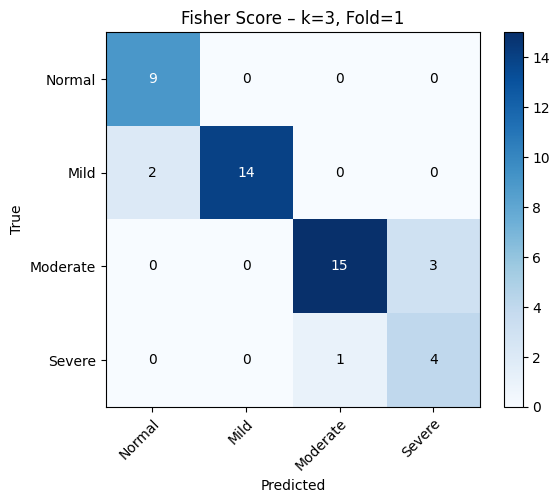

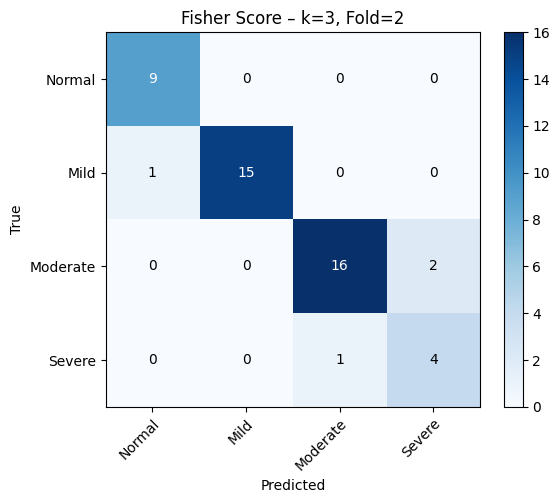

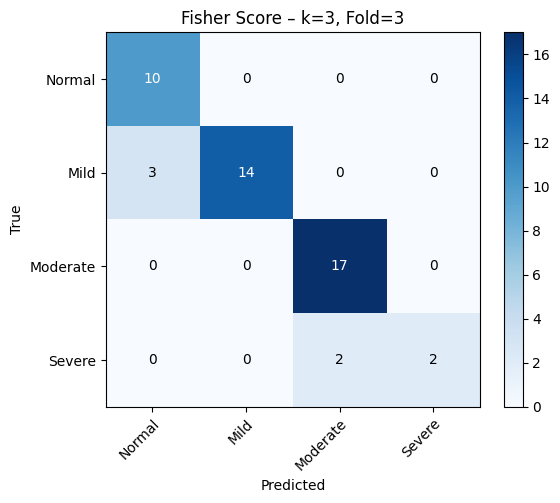

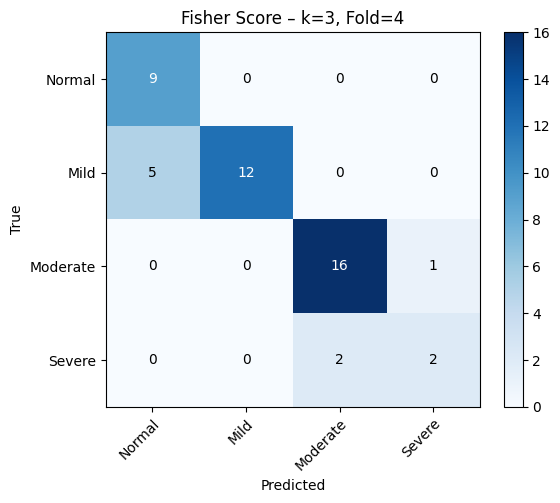

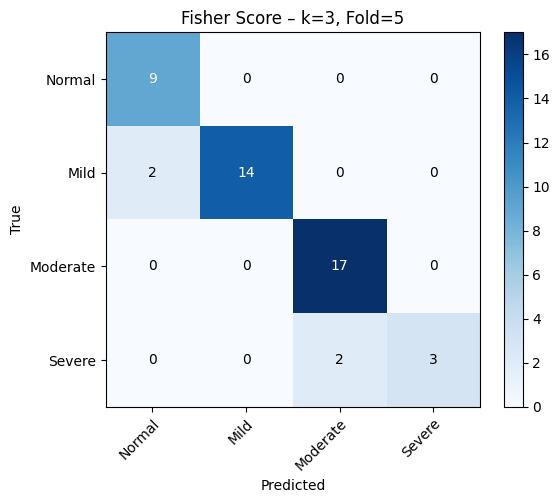


====== Fisher Score: k = 5 ======



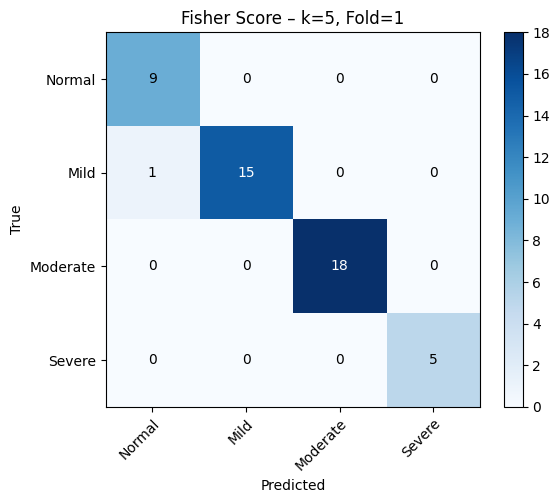

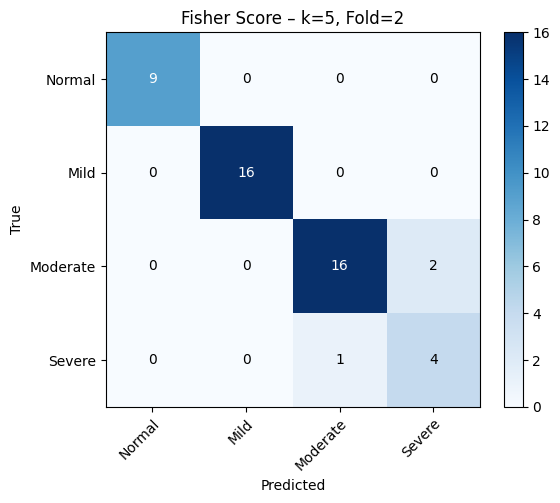

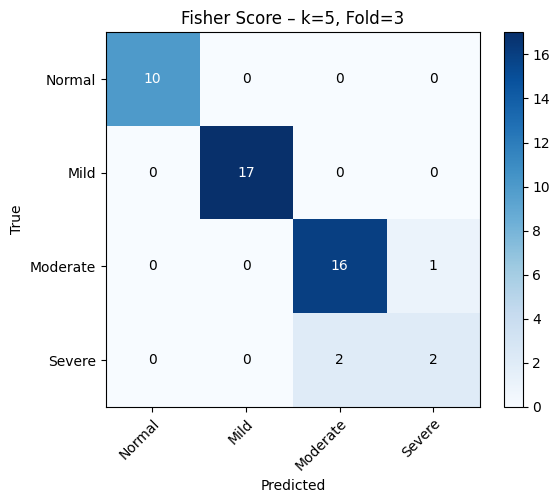

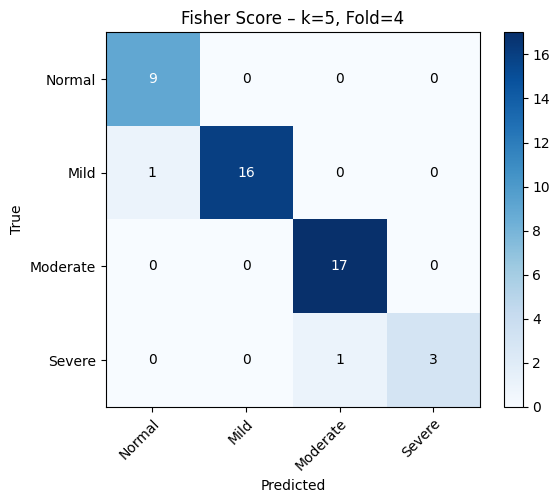

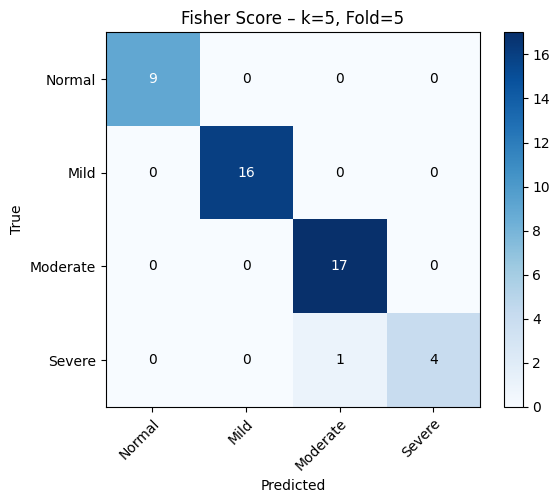


====== Fisher Score: k = 8 ======



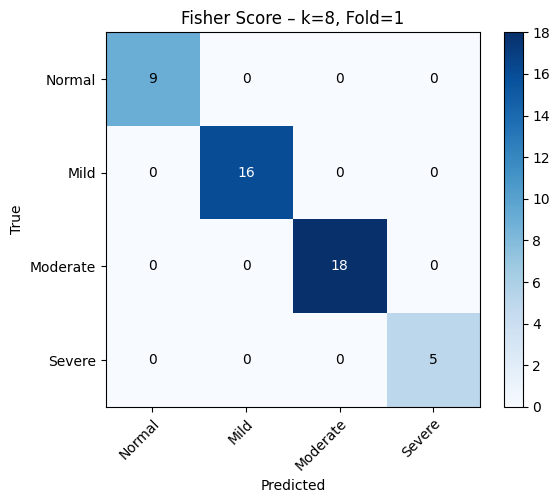

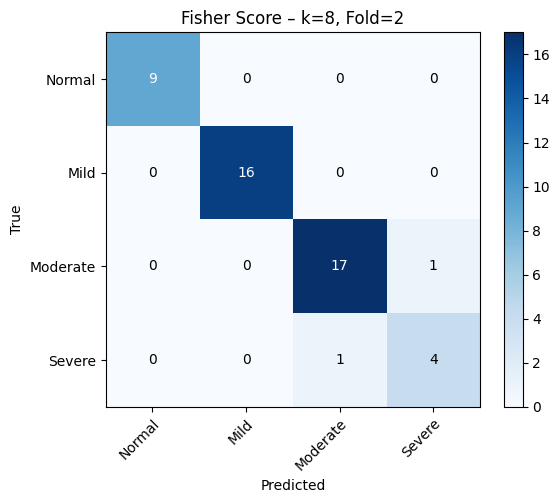

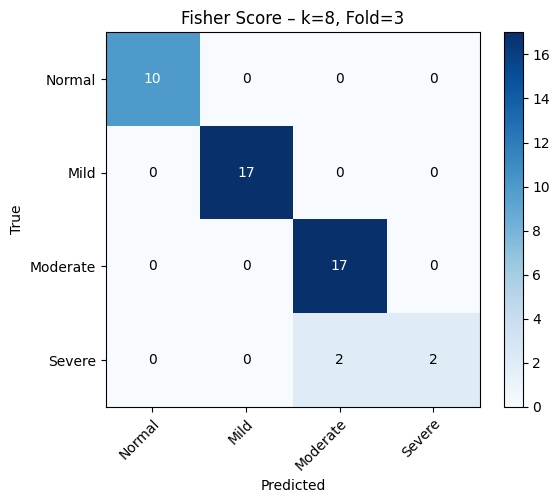

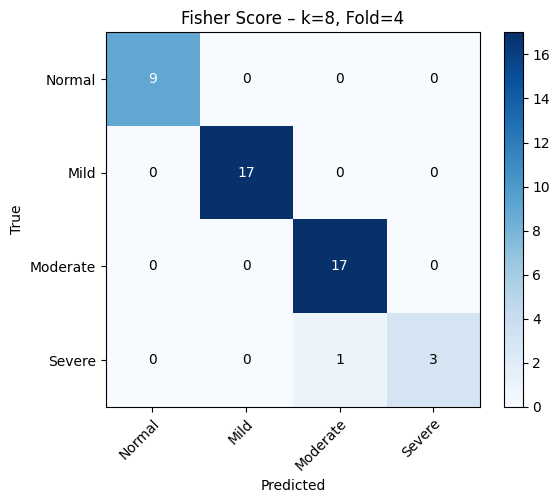

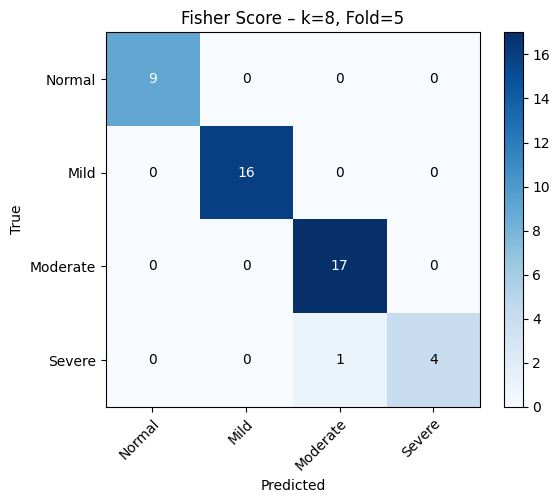


====== Fisher Score: k = 10 ======



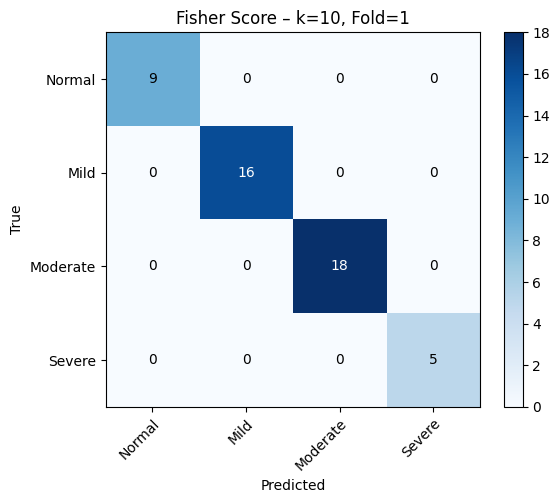

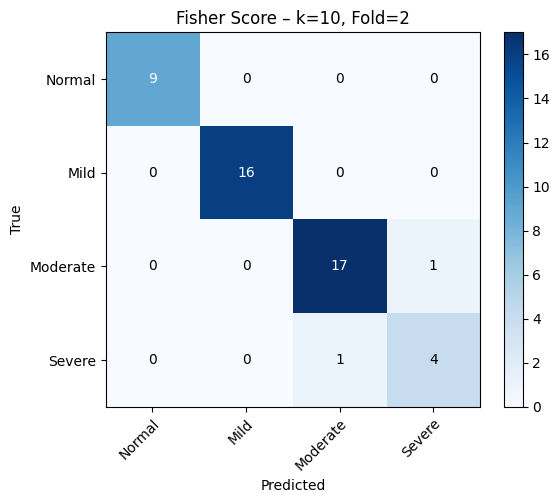

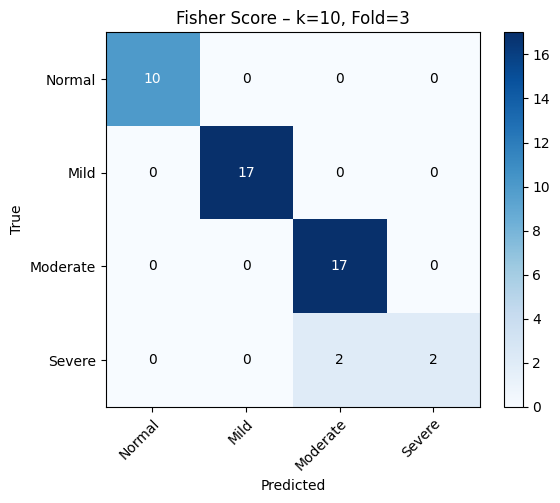

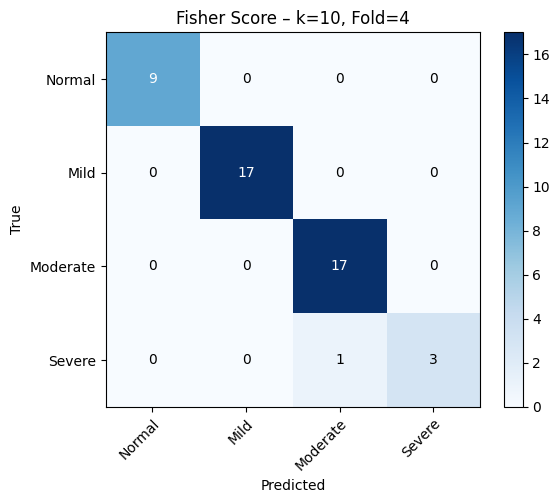

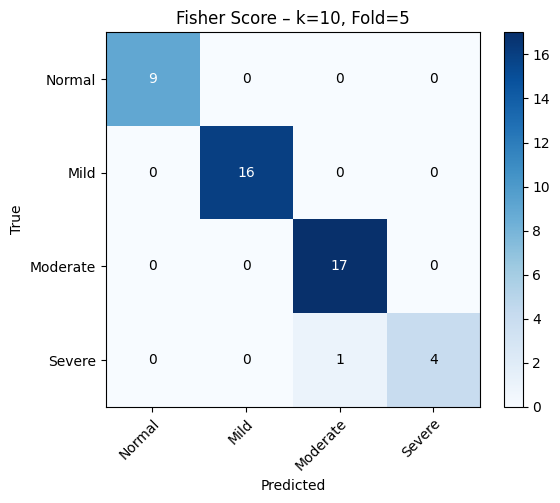


====== Fisher Score: k = 12 ======



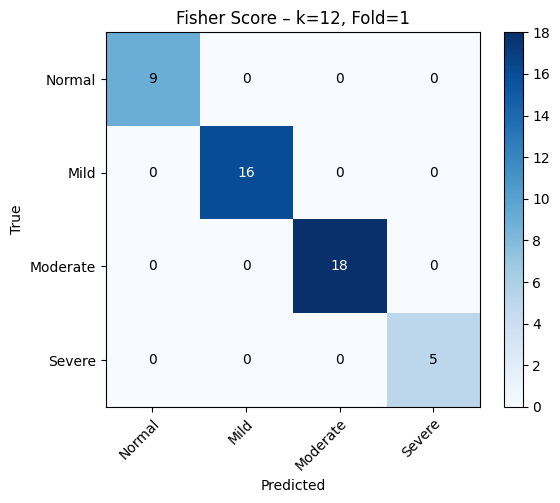

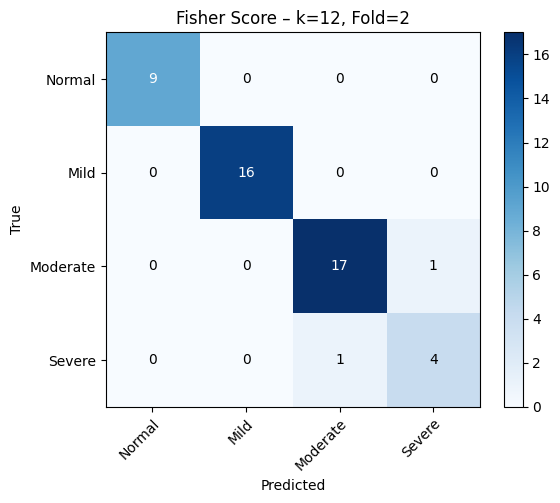

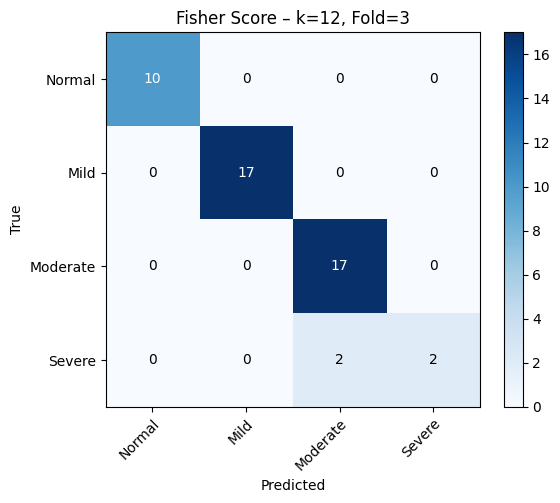

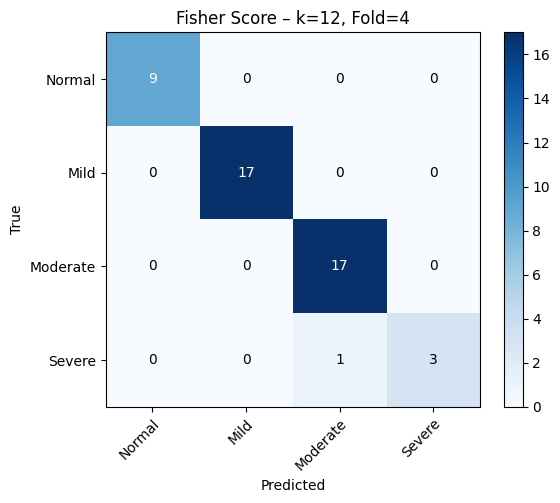

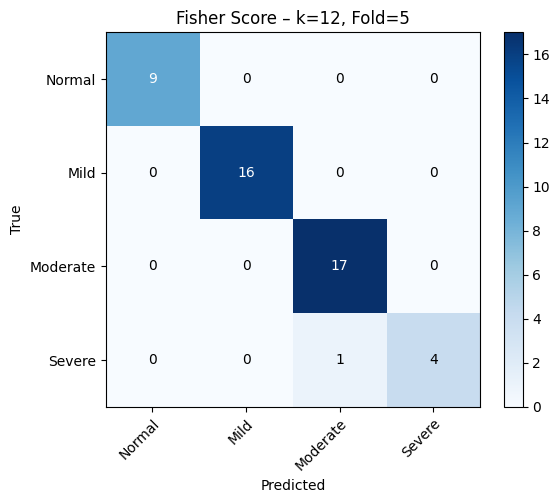


====== Fisher Score: k = 15 ======



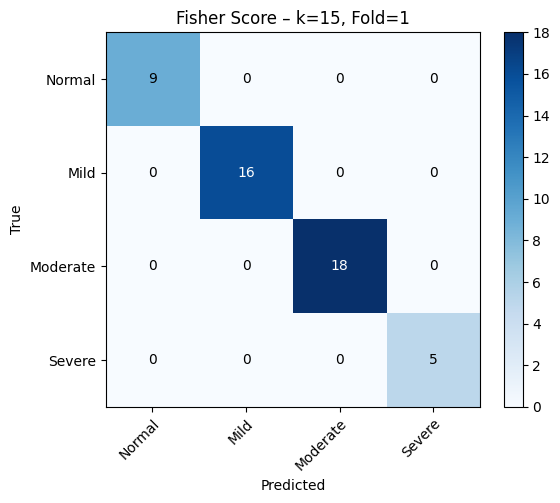

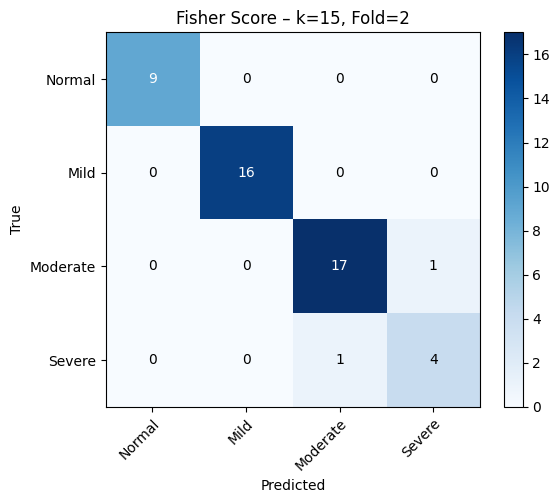

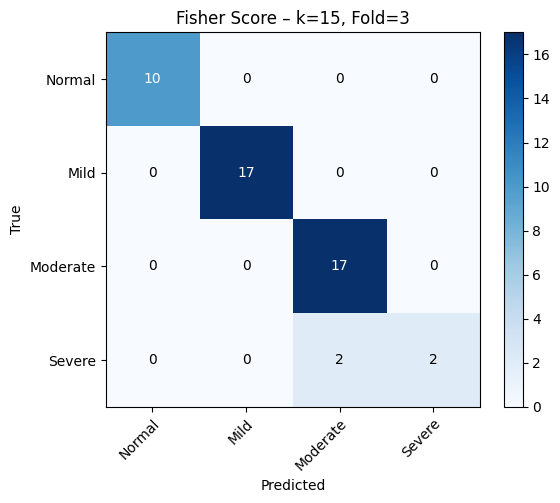

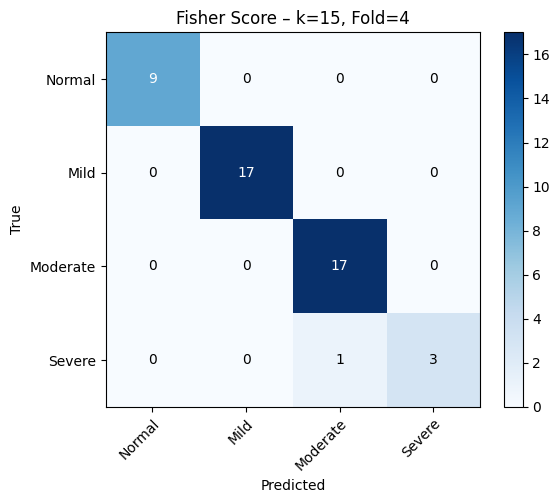

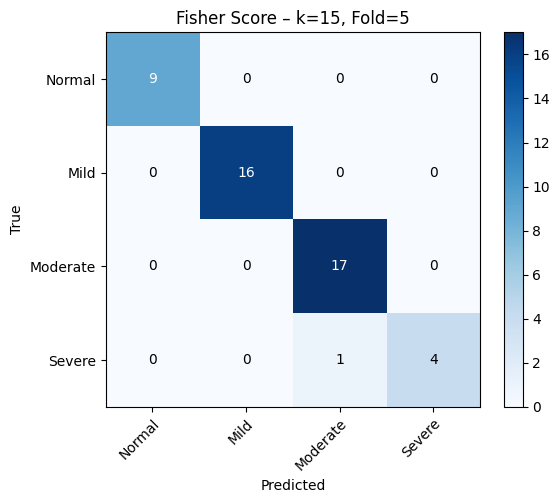


====== Fisher Score: k = 20 ======



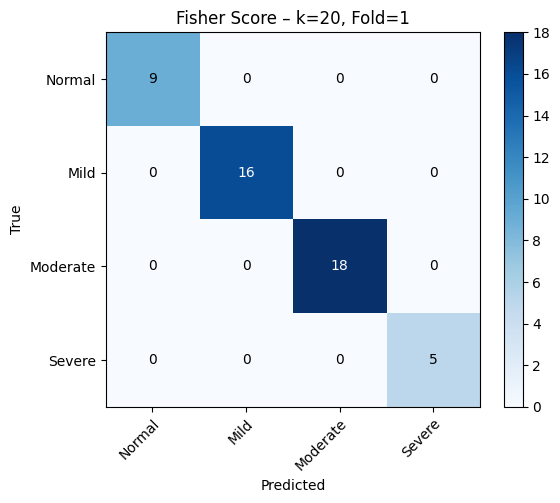

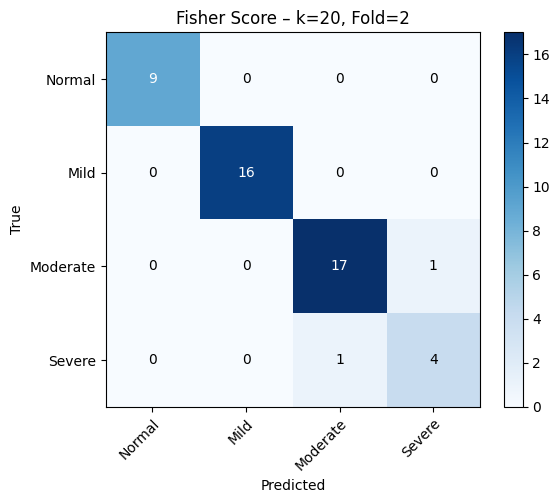

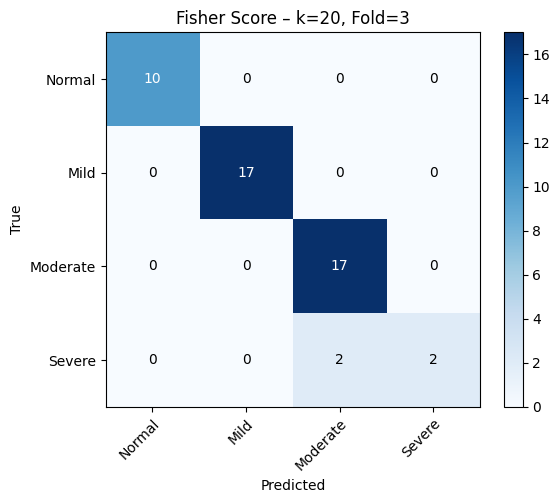

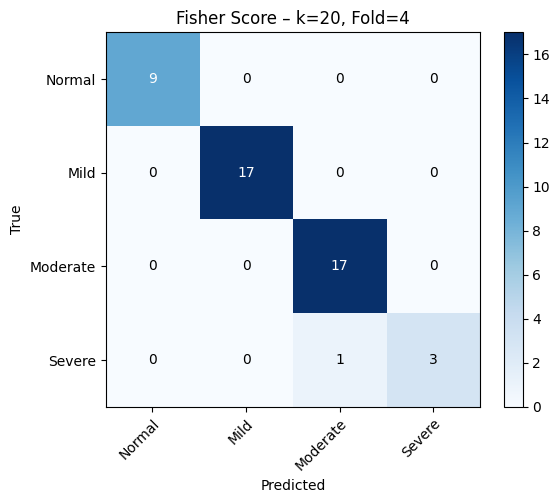

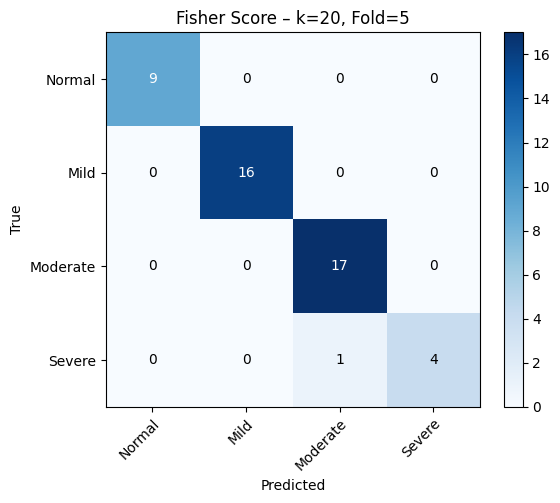

In [ ]:
class_names = ["Normal", "Mild", "Moderate", "Severe"]

for (method_name, k_display), folds_dict in cm_per.items():
    if method_name != "Fisher Score":
        continue  # skip other methods

    print(f"\n====== Fisher Score: k = {k_display} ======\n")
    for fold, cm in folds_dict.items():
        plot_confusion_matrix(
            cm,
            class_names=class_names,
            title=f"Fisher Score – k={k_display}, Fold={fold}"
        )



## aggregated (overall) confusion matrix

In [ ]:
def get_aggregated_confusion_matrix(cm_dict_for_k):
    """
    cm_dict_for_k = cm_per_k_fold[k_display]
    returns the sum of all fold confusion matrices
    """
    cms = list(cm_dict_for_k.values())       # [cm1, cm2, cm3, cm4, cm5]
    agg = np.sum(cms, axis=0)                # element-wise sum
    return agg


Fisher rows found:
           method   k
1   Fisher Score   3
3   Fisher Score   5
5   Fisher Score   8
7   Fisher Score  10
9   Fisher Score  12
11  Fisher Score  15
13  Fisher Score  20 


Plotting Fisher Score aggregated confusion matrix for k = 3


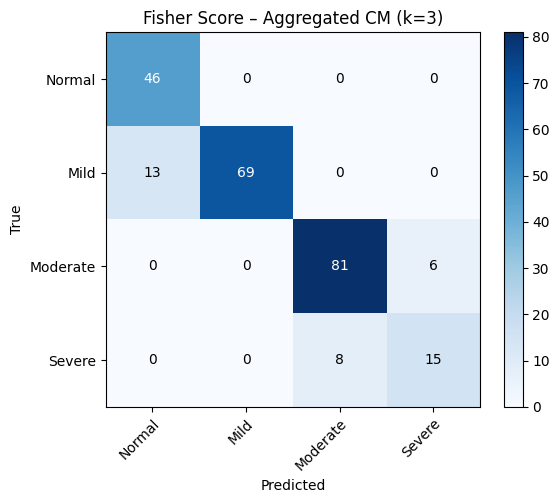


Plotting Fisher Score aggregated confusion matrix for k = 5


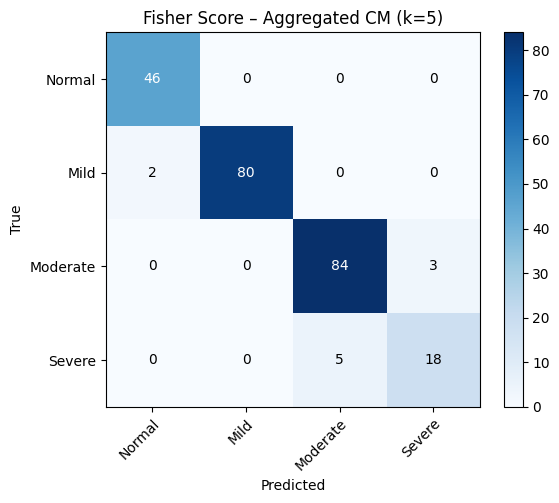


Plotting Fisher Score aggregated confusion matrix for k = 8


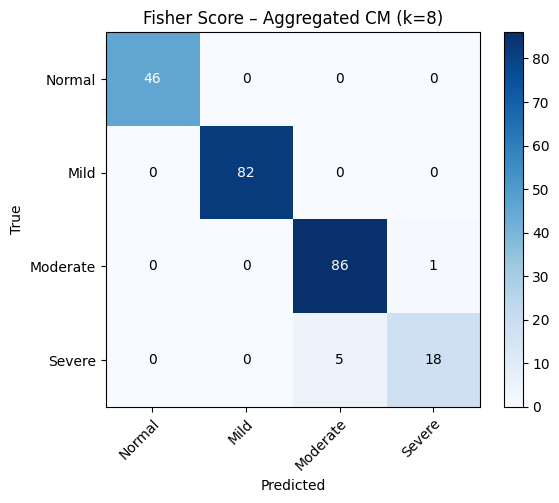


Plotting Fisher Score aggregated confusion matrix for k = 10


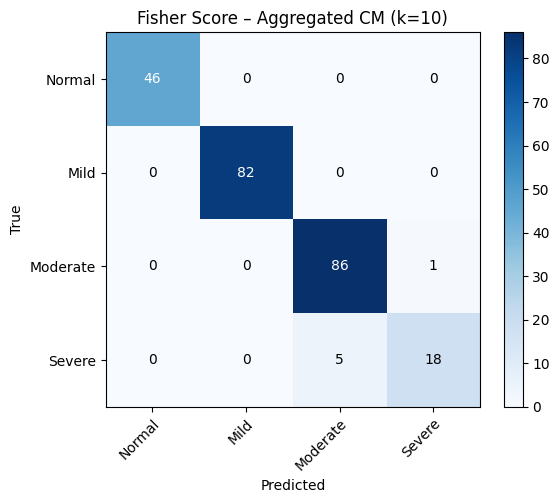


Plotting Fisher Score aggregated confusion matrix for k = 12


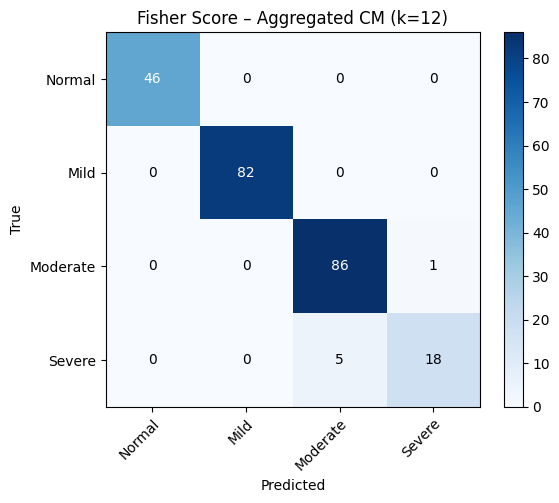


Plotting Fisher Score aggregated confusion matrix for k = 15


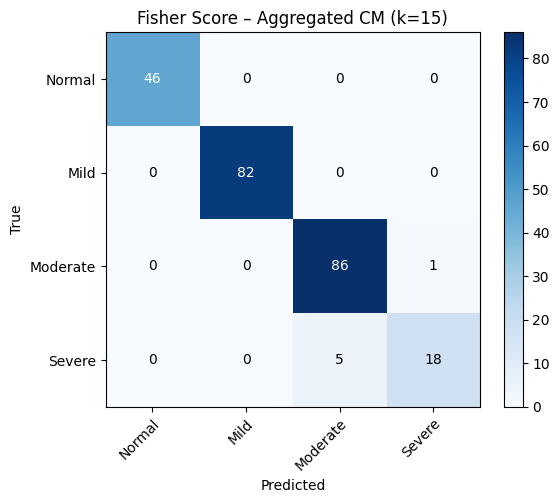


Plotting Fisher Score aggregated confusion matrix for k = 20


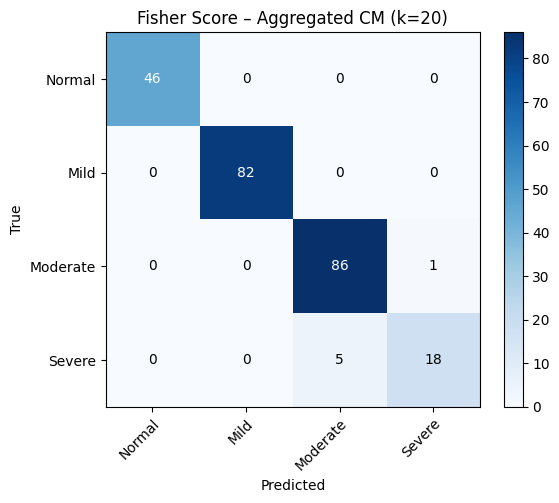

In [ ]:
# ===========================
# Plot aggregated CM for ALL Fisher Score k values
# ===========================

class_names = ["Normal", "Mild", "Moderate", "Severe"]

# Filter results_df to only keep Fisher Score rows
fisher_rows = results_df[results_df["method"] == "Fisher Score"]

print("Fisher rows found:\n", fisher_rows[["method", "k"]], "\n")

for idx, row in fisher_rows.iterrows():

    method_name = row["method"]        # "Fisher Score"
    k_display   = row["k"]             # 3, 5, 8, 10, 12, ...

    print(f"\n==============================")
    print(f"Plotting Fisher Score aggregated confusion matrix for k = {k_display}")
    print("==============================")

    # Get all 5 fold confusion matrices
    cm_dict_for_k = cm_per[(method_name, k_display)]

    # Aggregate (sum)
    cm_overall = get_aggregated_confusion_matrix(cm_dict_for_k)

    # Plot
    plot_confusion_matrix(
        cm_overall,
        class_names,
        title=f"Fisher Score – Aggregated CM (k={k_display})"
    )


## overfitting cheking

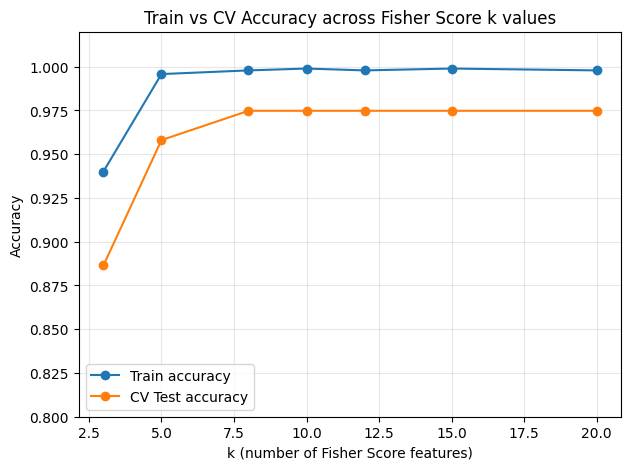

In [ ]:
# Filter only Fisher Score rows
fisher_df = results_df[results_df["method"] == "Fisher Score"].copy()

# Ensure k is numeric (not 'all')
fisher_df = fisher_df[fisher_df["k"] != "all"]

x_labels = fisher_df["k"].astype(int)

plt.figure(figsize=(7,5))
plt.plot(x_labels, fisher_df["train_mean_accuracy"], marker="o", label="Train accuracy")
plt.plot(x_labels, fisher_df["mean_accuracy"], marker="o", label="CV Test accuracy")

plt.xlabel("k (number of Fisher Score features)")
plt.ylabel("Accuracy")
plt.title("Train vs CV Accuracy across Fisher Score k values")
plt.ylim(0.8, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



# Model Implementaion with 8 Final Feature

In [ ]:
# Final Fisher Score features for k = 8
final_features = [
    "Fasciculation",
    "Polyphasic_Units",
    "Positive_Sharp_Waves",
    "Fibrillation",
    "MUAP_Amplitude (mV)",
    "MUAP_Duration (ms)",
    "time_since_injury_months",
    "injury_type"
]

# Make sure we're only using these columns from X
X_final = X[final_features].copy()

print("Final X shape:", X_final.shape)
print("Final features:", list(X_final.columns))

Final X shape: (238, 8)
Final features: ['Fasciculation', 'Polyphasic_Units', 'Positive_Sharp_Waves', 'Fibrillation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'time_since_injury_months', 'injury_type']


In [ ]:
X_final.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fasciculation             238 non-null    int64  
 1   Polyphasic_Units          238 non-null    int64  
 2   Positive_Sharp_Waves      238 non-null    int64  
 3   Fibrillation              238 non-null    int64  
 4   MUAP_Amplitude (mV)       238 non-null    float64
 5   MUAP_Duration (ms)        238 non-null    float64
 6   time_since_injury_months  238 non-null    float64
 7   injury_type               238 non-null    object 
dtypes: float64(3), int64(4), object(1)
memory usage: 42.2 KB


In [ ]:
print(X_final.dtypes)


Fasciculation                 int64
Polyphasic_Units              int64
Positive_Sharp_Waves          int64
Fibrillation                  int64
MUAP_Amplitude (mV)         float64
MUAP_Duration (ms)          float64
time_since_injury_months    float64
injury_type                  object
dtype: object


In [ ]:
final_cats = [col for col in final_features if X[col].dtype == "object"]
print("Categorical in final features:", final_cats)


Categorical in final features: ['injury_type']


In [ ]:
final_cat_clean_features = [
    "injury_type"
]


In [ ]:
accuracies   = []
macro_f1s    = []
macro_precisions = []
macro_recalls = []
mccs         = []
ap_severe_ls = []

cm_per_fold = {}   # to store confusion matrices per fold

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):
    # ----- Split data -----
    X_train = X_final.iloc[train_idx].copy()
    X_test  = X_final.iloc[test_idx].copy()
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # ----- Model -----
    cat_idx_all = [
        i for i, col in enumerate(X_train.columns)
        if col in final_cat_clean_features
    ]
    model = CatBoostClassifier(**base_params)
    model.fit(
        X_train,
        y_train,
        cat_features= cat_idx_all,
        verbose=False
      )
    '''
    cb_pool = Pool(
          data=X_train,
          label=y_train,
          cat_features=cat_idx_all
     )
    '''

    # ----- Predictions -----
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # ----- Metrics -----
    acc      = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    mcc      = matthews_corrcoef(y_test, y_pred)
    macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # AUC-PR for Severe class
    y_test_severe = (y_test == severe_label).astype(int)
    severe_index  = np.where(model.classes_ == severe_label)[0][0]
    severe_probs  = y_proba[:, severe_index]
    ap_severe     = average_precision_score(y_test_severe, severe_probs)

    # Save
    accuracies.append(acc)
    macro_f1s.append(macro_f1)
    mccs.append(mcc)
    macro_precisions.append(macro_precision)
    macro_recalls.append(macro_recall)
    ap_severe_ls.append(ap_severe)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_per_fold[fold] = cm

    print(
        f"Fold {fold} - "
        f"Acc: {acc:.3f}, "
        f"Macro F1: {macro_f1:.3f}, "
        f"Precision: {macro_precision:.3f}, "
        f"Recall: {macro_recall:.3f}, "
        f"MCC: {mcc:.3f}, "
        f"AP_severe: {ap_severe:.3f}"
    )

# ===== Final averaged metrics =====
print("\n===== FINAL 5-fold CV (Fisher k=8) =====")
print("Mean Accuracy:    ", np.mean(accuracies))
print("Mean Macro F1:    ", np.mean(macro_f1s))
print("Mean Precision:   ", np.mean(macro_precisions))
print("Mean Recall:      ", np.mean(macro_recalls))
print("Mean MCC:         ", np.mean(mccs))
print("Mean AP_severe:   ", np.mean(ap_severe_ls))


Fold 1 - Acc: 1.000, Macro F1: 1.000, Precision: 1.000, Recall: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 2 - Acc: 0.958, Macro F1: 0.936, Precision: 0.936, Recall: 0.936, MCC: 0.941, AP_severe: 0.891
Fold 3 - Acc: 0.958, Macro F1: 0.903, Precision: 0.974, Recall: 0.875, MCC: 0.942, AP_severe: 0.640
Fold 4 - Acc: 0.979, Macro F1: 0.957, Precision: 0.986, Recall: 0.938, MCC: 0.970, AP_severe: 1.000
Fold 5 - Acc: 0.979, Macro F1: 0.965, Precision: 0.986, Recall: 0.950, MCC: 0.970, AP_severe: 0.925

===== FINAL 5-fold CV (Fisher k=8) =====
Mean Accuracy:     0.974822695035461
Mean Macro F1:     0.9522222222222222
Mean Precision:    0.9764035087719298
Mean Recall:       0.9397222222222222
Mean MCC:          0.9645296629446474
Mean AP_severe:    0.8911038961038962


# hyperparameter tuning with k = 8 + Retrain Tuned Final Model

In [ ]:
# We will use X_final (only the 8 Fisher features) and y
# And freq_cols_final, severe_label, classes that you already defined

# ------------ regularized search space ------------
from itertools import product

param_grid = {
    "depth": [3, 4, 6,8],
    "learning_rate": [0.02, 0.03,0.05],
    "iterations": [200, 300],
    "l2_leaf_reg": [3, 5, 7],
    "random_strength": [1, 3, 5]
}


In [ ]:
# All combinations

keys = list(param_grid.keys())
param_combos = list(product(*param_grid.values()))
print("Total combinations:", len(param_combos))



Total combinations: 216


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tuning_rows = []

In [ ]:
for combo in param_combos:
    params = dict(zip(keys, combo))
    print("\nTesting params:", params)

    fold_macro_f1 = []
    fold_ap_severe = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):
        # ----- Split -----
        X_train = X_final.iloc[train_idx].copy()
        X_test  = X_final.iloc[test_idx].copy()
        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]

        # ------------------------------
        # CatBoost model with current params
        # ------------------------------
        model = CatBoostClassifier(
            **params,
            loss_function="MultiClass",
            eval_metric="TotalF1",
            random_state=42,
            verbose=False,
        )

        model.fit(
            X_train,
            y_train,
            cat_features=final_cat_clean_features,
            verbose=False
        )

        # ----- TEST metrics -----
        y_pred  = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        # AP for severe
        y_test_severe = (y_test == severe_label).astype(int)
        severe_index  = np.where(model.classes_ == severe_label)[0][0]
        severe_probs  = y_proba[:, severe_index]
        ap_severe     = average_precision_score(y_test_severe, severe_probs)

        fold_macro_f1.append(macro_f1)
        fold_ap_severe.append(ap_severe)

    # mean scores for this param combo
    row = {
        **params,
        "mean_macro_f1": np.mean(fold_macro_f1),
        "mean_AP_severe": np.mean(fold_ap_severe),
    }
    tuning_rows.append(row)
    print("  -> mean_macro_f1 = %.4f, mean_AP_severe = %.4f" %
          (row["mean_macro_f1"], row["mean_AP_severe"]))





Testing params: {'depth': 3, 'learning_rate': 0.02, 'iterations': 200, 'l2_leaf_reg': 3, 'random_strength': 1}
  -> mean_macro_f1 = 0.9136, mean_AP_severe = 0.8877

Testing params: {'depth': 3, 'learning_rate': 0.02, 'iterations': 200, 'l2_leaf_reg': 3, 'random_strength': 3}
  -> mean_macro_f1 = 0.8660, mean_AP_severe = 0.8964

Testing params: {'depth': 3, 'learning_rate': 0.02, 'iterations': 200, 'l2_leaf_reg': 3, 'random_strength': 5}
  -> mean_macro_f1 = 0.8216, mean_AP_severe = 0.9013

Testing params: {'depth': 3, 'learning_rate': 0.02, 'iterations': 200, 'l2_leaf_reg': 5, 'random_strength': 1}
  -> mean_macro_f1 = 0.9136, mean_AP_severe = 0.8990

Testing params: {'depth': 3, 'learning_rate': 0.02, 'iterations': 200, 'l2_leaf_reg': 5, 'random_strength': 3}
  -> mean_macro_f1 = 0.8038, mean_AP_severe = 0.8836

Testing params: {'depth': 3, 'learning_rate': 0.02, 'iterations': 200, 'l2_leaf_reg': 5, 'random_strength': 5}
  -> mean_macro_f1 = 0.7421, mean_AP_severe = 0.8949

Testing p

In [ ]:
# Put all tuning results into a DataFrame
tuning_df = pd.DataFrame(tuning_rows)
print("\n=== Hyperparameter tuning results (sorted by Macro F1) ===")
tuning_df = tuning_df.sort_values(by="mean_macro_f1", ascending=False)

print("\n=== TOP 10 CatBoost TUNING RESULTS ===")
print(tuning_df.head(10))



=== Hyperparameter tuning results (sorted by Macro F1) ===

=== TOP 10 CatBoost TUNING RESULTS ===
     depth  learning_rate  iterations  l2_leaf_reg  random_strength  \
105      4           0.05         300            7                1   
102      4           0.05         300            5                1   
45       3           0.05         300            3                1   
47       3           0.05         300            3                5   
101      4           0.05         300            3                5   
53       3           0.05         300            7                5   
52       3           0.05         300            7                3   
50       3           0.05         300            5                5   
106      4           0.05         300            7                3   
156      6           0.05         300            5                1   

     mean_macro_f1  mean_AP_severe  
105       0.949799        0.892468  
102       0.949799        0.899306  
45     

In [ ]:
best_cb_params = tuning_df.iloc[0][keys].to_dict()
print("Best CatBoost Params:", best_cb_params)

Best CatBoost Params: {'depth': 4.0, 'learning_rate': 0.05, 'iterations': 300.0, 'l2_leaf_reg': 7.0, 'random_strength': 1.0}


In [ ]:
best_cb_params = {
    "depth": 4,
    "learning_rate": 0.05,
    "iterations":  300,
    "l2_leaf_reg": 7,
    "random_strength": 1
}

print("Chosen best_params:", best_cb_params)



Chosen best_params: {'depth': 4, 'learning_rate': 0.05, 'iterations': 300, 'l2_leaf_reg': 7, 'random_strength': 1}


In [ ]:
# Lists for TEST metrics
accuracies        = []
macro_f1s         = []
macro_precisions  = []
macro_recalls     = []
mccs              = []
ap_severe_ls      = []

# Lists for TRAIN metrics (for overfitting check)
train_accuracies   = []
train_macro_f1s    = []
train_macro_precs  = []
train_macro_recalls = []
train_mccs         = []

cm_per_fold = {}   # to store confusion matrices per fold (TEST)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):
    # ----- Split data -----
    X_train = X_final.iloc[train_idx].copy()
    X_test  = X_final.iloc[test_idx].copy()
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]



    # ----- Tuned Model -----
    cat_idx = [
        i for i, col in enumerate(X_final.columns)
        if col in clean_cat_features
    ]

    model = CatBoostClassifier(**best_cb_params)

    model.fit(
        X_train,
        y_train,
        cat_features= cat_idx,
        verbose=False
     )


    # ============ TRAIN predictions ============
    y_train_pred = model.predict(X_train)

    train_acc      = accuracy_score(y_train, y_train_pred)
    train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_macro_p  = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_macro_r  = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_mcc      = matthews_corrcoef(y_train, y_train_pred)

    train_accuracies.append(train_acc)
    train_macro_f1s.append(train_macro_f1)
    train_macro_precs.append(train_macro_p)
    train_macro_recalls.append(train_macro_r)
    train_mccs.append(train_mcc)

    # ============ TEST predictions ============
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # ----- TEST Metrics -----
    acc      = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
    mcc      = matthews_corrcoef(y_test, y_pred)

    # AUC-PR for Severe class
    y_test_severe = (y_test == severe_label).astype(int)
    severe_index  = np.where(model.classes_ == severe_label)[0][0]
    severe_probs  = y_proba[:, severe_index]
    ap_severe     = average_precision_score(y_test_severe, severe_probs)

    # Save TEST metrics
    accuracies.append(acc)
    macro_f1s.append(macro_f1)
    macro_precisions.append(macro_precision)
    macro_recalls.append(macro_recall)
    mccs.append(mcc)
    ap_severe_ls.append(ap_severe)

    # Confusion matrix (TEST)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_per_fold[fold] = cm

    print(
    f"Fold {fold} - "
    f"Train Acc: {train_acc*100}%, Test Acc: {acc*100}%, "
    f"Train F1: {train_macro_f1*100}%, Test F1: {macro_f1*100}%, "
    f"Train MCC: {train_mcc*100}%, Test MCC: {mcc*100}%, "
    f"AP_severe (test): {ap_severe*100}%"
    )


Fold 1 - Train Acc: 97.89473684210527%, Test Acc: 100.0%, Train F1: 96.17077464788733%, Test F1: 100.0%, Train MCC: 97.03604588845889%, Test MCC: 100.0%, AP_severe (test): 100.0%
Fold 2 - Train Acc: 98.42105263157895%, Test Acc: 97.91666666666666%, Train F1: 97.1953578336557%, Test F1: 96.54654654654654%, Train MCC: 97.76946260586648%, Test MCC: 97.07352309160528%, AP_severe (test): 87.14285714285714%
Fold 3 - Train Acc: 98.94736842105263%, Test Acc: 95.83333333333334%, Train F1: 98.25899843505476%, Test F1: 90.27777777777779%, Train MCC: 98.50951733349123%, Test MCC: 94.1941961261464%, AP_severe (test): 63.96103896103895%
Fold 4 - Train Acc: 97.90575916230367%, Test Acc: 97.87234042553192%, Train F1: 96.36437908496733%, Test F1: 95.71428571428572%, Train MCC: 97.05945264350136%, Test MCC: 96.97779779508043%, AP_severe (test): 100.0%
Fold 5 - Train Acc: 98.42931937172776%, Test Acc: 97.87234042553192%, Train F1: 97.20279720279721%, Test F1: 96.5079365079365%, Train MCC: 97.778707407183

In [ ]:
# ===== Final averaged metrics (TEST) =====
print("\n===== FINAL 5-fold CV (Tuned CatBoost , Fisher k=8) =====\n\n")
print("Mean Train Accuracy:   ", np.mean(train_accuracies))
print("Mean Test  Accuracy:   ", np.mean(accuracies))
print("\nMean Train Macro F1:   ", np.mean(train_macro_f1s))
print("Mean Test  Macro F1:   ", np.mean(macro_f1s))
print("\nMean Train MCC:        ", np.mean(train_mccs))
print("Mean Test  MCC:        ", np.mean(mccs))
print("\nMean Test Precision:   ", np.mean(macro_precisions))
print("Mean Test Recall:      ", np.mean(macro_recalls))
print("Mean Test AP_severe:   ", np.mean(ap_severe_ls))


===== FINAL 5-fold CV (Tuned CatBoost , Fisher k=8) =====


Mean Train Accuracy:    0.9831964728575366
Mean Test  Accuracy:    0.9789893617021276

Mean Train Macro F1:    0.9703846144087247
Mean Test  Macro F1:    0.9580930930930931

Mean Train MCC:         0.9763063717570022
Mean Test  MCC:         0.9705432109819989

Mean Test Precision:    0.9865497076023392
Mean Test Recall:       0.9425000000000001
Mean Test AP_severe:    0.8803896103896104


## Plotting confusion matrix per fold


=== Confusion Matrix – Fold 1 ===


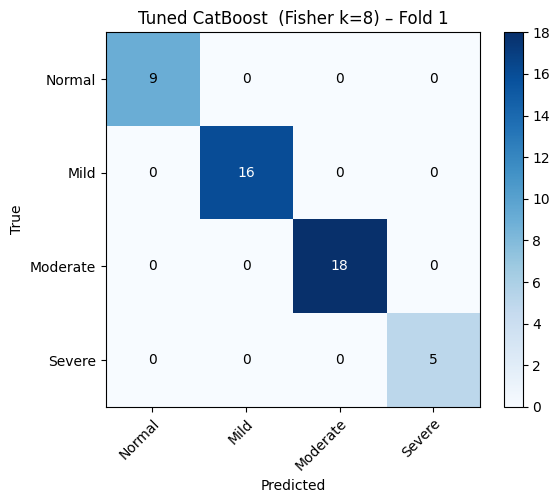


=== Confusion Matrix – Fold 2 ===


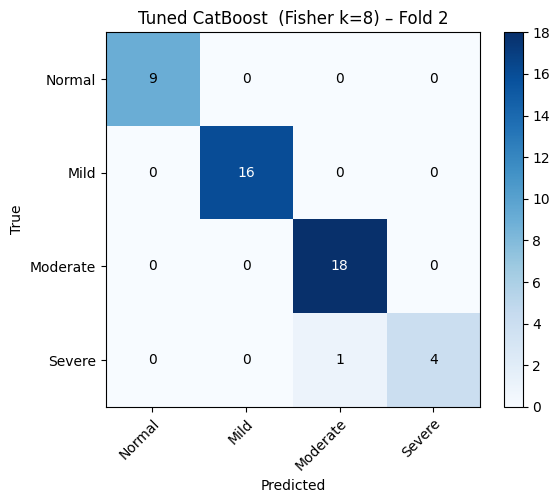


=== Confusion Matrix – Fold 3 ===


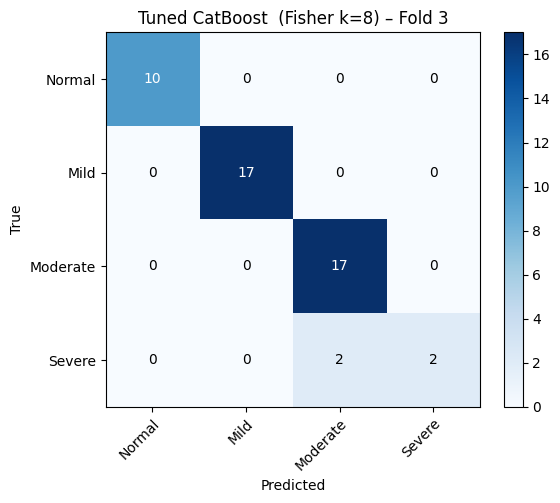


=== Confusion Matrix – Fold 4 ===


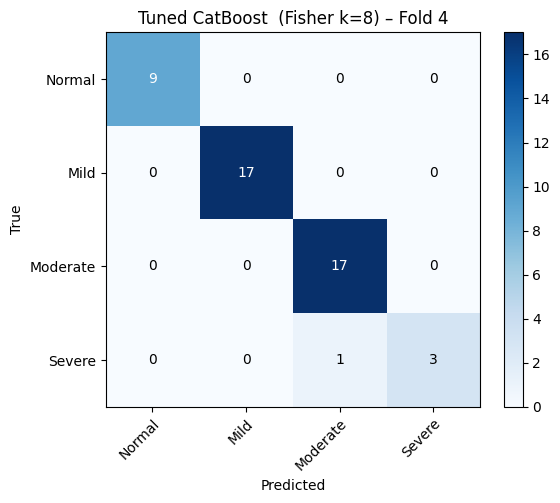


=== Confusion Matrix – Fold 5 ===


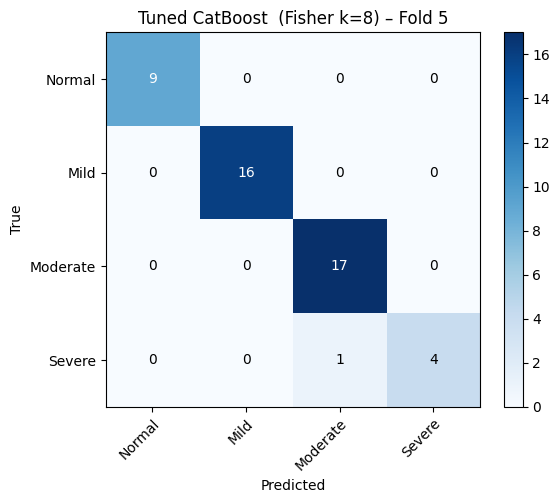

In [ ]:
# Make sure this matches the order you used in confusion_matrix(labels=...)
# If you used 'classes = np.sort(y.unique())', you can do:
# class_names = list(classes)
class_names = ["Normal", "Mild", "Moderate", "Severe"]

for fold, cm in cm_per_fold.items():
    print(f"\n=== Confusion Matrix – Fold {fold} ===")
    plot_confusion_matrix(
        cm,
        class_names,
        title=f"Tuned CatBoost  (Fisher k=8) – Fold {fold}"
    )


## aggregated (overall) confusion matrix


=== Aggregated Confusion Matrix over 5 folds ===
[[46  0  0  0]
 [ 0 82  0  0]
 [ 0  0 87  0]
 [ 0  0  5 18]]


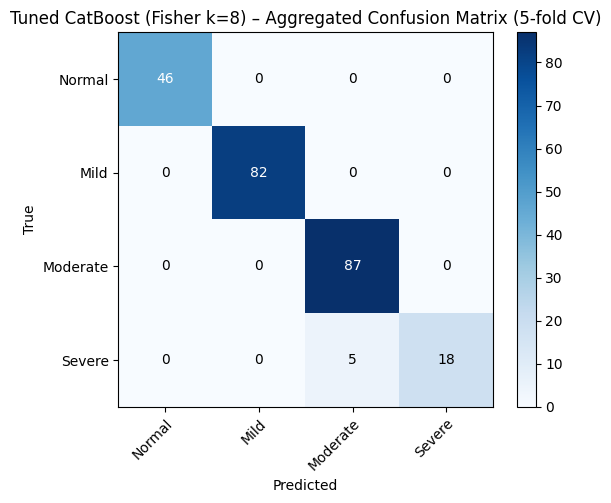

In [ ]:
def get_aggregated_confusion_matrix(cm_dict):
    """
    cm_dict: dictionary {fold_id: confusion_matrix}
    returns the sum of all fold confusion matrices (overall CM)
    """
    cms = list(cm_dict.values())      # [cm1, cm2, cm3, cm4, cm5]
    agg = np.sum(cms, axis=0)         # element-wise sum
    return agg

cm_overall = get_aggregated_confusion_matrix(cm_per_fold)

print("\n=== Aggregated Confusion Matrix over 5 folds ===")
print(cm_overall)

plot_confusion_matrix(
    cm_overall,
    class_names,
    title="Tuned CatBoost (Fisher k=8) – Aggregated Confusion Matrix (5-fold CV)"
)


In [ ]:
print("\n===== Per-Class Metrics (averaged across folds) =====")

# Convert overall CM → per-class metrics
per_class_accuracy = {}
per_class_precision = {}
per_class_recall = {}
per_class_f1 = {}

for i, cls in enumerate(class_names):

    TP = cm_overall[i, i]
    FN = np.sum(cm_overall[i, :]) - TP
    FP = np.sum(cm_overall[:, i]) - TP

    # Accuracy (per class)
    accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1-score
    f1 = (2 * TP) / (2*TP + FP + FN) if (2*TP + FP + FN) > 0 else 0

    per_class_accuracy[cls] = accuracy
    per_class_precision[cls] = precision
    per_class_recall[cls] = recall
    per_class_f1[cls] = f1

    print(f"\nClass: {cls}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

# Optional: print summary
print("\n===== Averages Across Classes =====")
print("Average per-class Accuracy:", np.mean(list(per_class_accuracy.values())))
print("Average per-class Precision:", np.mean(list(per_class_precision.values())))
print("Average per-class Recall:", np.mean(list(per_class_recall.values())))
print("Average per-class F1:", np.mean(list(per_class_f1.values())))


===== Per-Class Metrics (averaged across folds) =====

Class: Normal
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000

Class: Mild
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000

Class: Moderate
  Accuracy:  1.0000
  Precision: 0.9457
  Recall:    1.0000
  F1-score:  0.9721

Class: Severe
  Accuracy:  0.7826
  Precision: 1.0000
  Recall:    0.7826
  F1-score:  0.8780

===== Averages Across Classes =====
Average per-class Accuracy: 0.9456521739130435
Average per-class Precision: 0.9864130434782609
Average per-class Recall: 0.9456521739130435
Average per-class F1: 0.9625289548984874


## Overfit Checking

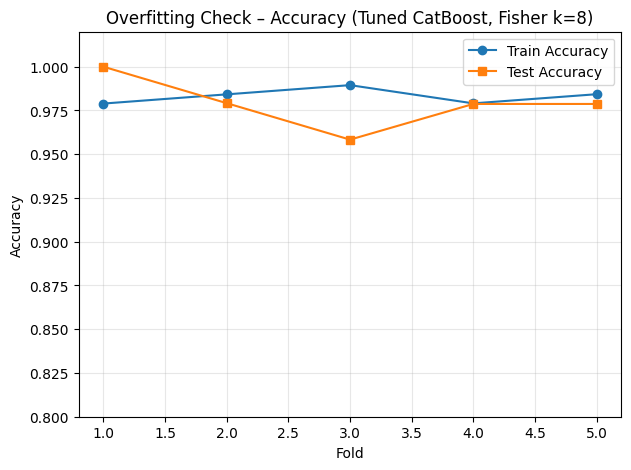

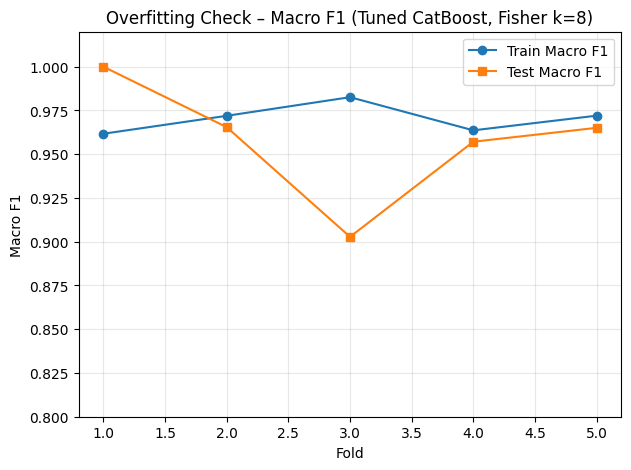

In [ ]:
fold_ids = np.arange(1, 6)

# -------- Accuracy Plot --------
plt.figure(figsize=(7,5))
plt.plot(fold_ids, train_accuracies, marker='o', label="Train Accuracy")
plt.plot(fold_ids, accuracies, marker='s', label="Test Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Overfitting Check – Accuracy (Tuned CatBoost, Fisher k=8)")
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.02)
plt.legend()
plt.show()

# -------- Macro F1 Plot --------
plt.figure(figsize=(7,5))
plt.plot(fold_ids, train_macro_f1s, marker='o', label="Train Macro F1")
plt.plot(fold_ids, macro_f1s, marker='s', label="Test Macro F1")
plt.xlabel("Fold")
plt.ylabel("Macro F1")
plt.title("Overfitting Check – Macro F1 (Tuned CatBoost, Fisher k=8)")
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.02)
plt.legend()
plt.show()

# Re-fit Final Model - SANDS CatBoost Class

In [ ]:
# 1) Make a copy of X_final and do frequency encoding on ALL rows
X_all = X_final.copy()
feature_order = list(X_all.columns)

print("X_all shape:", X_all.shape)
print("\nFinal features used for training / feature_order = list(X_all.columns):", list(X_all.columns))

X_all shape: (238, 8)

Final features used for training / feature_order = list(X_all.columns): ['Fasciculation', 'Polyphasic_Units', 'Positive_Sharp_Waves', 'Fibrillation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'time_since_injury_months', 'injury_type']


In [ ]:
# 2) Identify categorical columns and their indices for CatBoost  (CatBoost needs column indices for categorical features)

# clean_cat_features = list of all categorical col names in the clean dataframe - we take only the intersection with the final features
cat_cols_final = [c for c in X_all.columns if c in final_cat_clean_features]

# Convert column names -> integer indices
cat_idx_final = [i for i, c in enumerate(X_all.columns) if c in cat_cols_final]

print("Categorical columns in FINAL model:", cat_cols_final)
print("Categorical indices passed to CatBoost:", cat_idx_final)

print("\nFinal features Types: \n", X_all.dtypes)


Categorical columns in FINAL model: ['injury_type']
Categorical indices passed to CatBoost: [7]

Final features Types: 
 Fasciculation                 int64
Polyphasic_Units              int64
Positive_Sharp_Waves          int64
Fibrillation                  int64
MUAP_Amplitude (mV)         float64
MUAP_Duration (ms)          float64
time_since_injury_months    float64
injury_type                  object
dtype: object


In [ ]:
# 3) Build the FINAL CatBoost model using tuned hyperparameters   -    best_cb_params: dict that you chose from tuning step

final_cb_model = CatBoostClassifier(**best_cb_params)



In [ ]:
# 4) Train on 100% of the data (ALL rows)

final_cb_model.fit(
    X_all,
    y,                      # full target vector
    cat_features=cat_idx_final,
    verbose=False
)

print("Final CatBoost model trained on ALL data.")

Final CatBoost model trained on ALL data.


In [ ]:
class SANDSModel:
    """
    SANDSModel
    ----------
    Wrapper around a trained CatBoost model providing:
    - Feature encoding
    - Real-time user input collection
    - Prediction with class probabilities
    """

    def __init__(self, catboost_model, feature_order, cat_idx_final, label_map=None):

        # Store trained model + feature metadata
        self.model = catboost_model
        self.feature_order = feature_order
        self.cat_idx_final = cat_idx_final

        # Numerical → Severity label mapping
        self.label_map = label_map or {
            0: "Normal",
            1: "Mild",
            2: "Moderate",
            3: "Severe"
        }

        # Ordinal encoding rules for neuromuscular features
        self.neurometric_encoding = {
            "Fasciculation": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            },
            "Positive_Sharp_Waves": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            },
            "Fibrillation": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            }
        }


    # 1) USER INPUT ENCODING (Raw → Numerical → DataFrame)

    def encode_user_input(self, user_input):
        """
        Converts raw user inputs (strings/numbers) into a numerical
        DataFrame matching the trained model's feature order.
        """

        def encode_neuro(feature, value):
            """Apply ordinal encoding to neuromuscular fields."""
            if feature in self.neurometric_encoding:
                return self.neurometric_encoding[feature].get(value, 0)
            return value

        final = {
            "Fasciculation": encode_neuro("Fasciculation", user_input["Fasciculation"]),
            "Positive_Sharp_Waves": encode_neuro("Positive_Sharp_Waves", user_input["Positive_Sharp_Waves"]),
            "Fibrillation": encode_neuro("Fibrillation", user_input["Fibrillation"]),

            # Convert numeric fields
            "Polyphasic_Units": int(user_input["Polyphasic_Units"]),
            "MUAP_Amplitude (mV)": float(user_input["MUAP_Amplitude (mV)"]),
            "MUAP_Duration (ms)": float(user_input["MUAP_Duration (ms)"]),
            "time_since_injury_months": float(user_input["time_since_injury_months"]),

            # Categorical feature (CatBoost handles string categories)
            "injury_type": user_input["injury_type"]
        }

        import pandas as pd
        return pd.DataFrame([final])


    # 2) REAL-TIME USER INPUT COLLECTION (Interactive)

    def realtime_user_input(self):
        """
        Interactive CLI-style questionnaire used to collect user inputs.
        """

        def ask_neuro(feature_name):
            """Prompt user to choose from neuromuscular ordinal options."""
            print(f"\n{feature_name} options:")
            print("  1) Absent")
            print("  2) Present (1+)")
            print("  3) Present (2+)")
            print("  4) Present (3+)")

            while True:
                c = input(f"Choose {feature_name} (1-4): ").strip()
                if c == "1": return "Absent"
                if c == "2": return "Present (1+)"
                if c == "3": return "Present (2+)"
                if c == "4": return "Present (3+)"
                print("Invalid input. Try again.")

        user = {}

        # Collect neuromuscular fields
        user["Fasciculation"]     = ask_neuro("Fasciculation")
        user["Positive_Sharp_Waves"] = ask_neuro("Positive_Sharp_Waves")
        user["Fibrillation"]      = ask_neuro("Fibrillation")

        # Numeric inputs
        user["Polyphasic_Units"]         = input("\nPolyphasic Units: ")
        user["MUAP_Amplitude (mV)"]      = input("MUAP Amplitude (mV): ")
        user["MUAP_Duration (ms)"]       = input("MUAP Duration (ms): ")
        user["time_since_injury_months"] = input("Time Since Injury (months): ")

        # Categorical input
        user["injury_type"] = input("\nInjury Type: ")

        return user


    # 3) ENSURE CORRECT FEATURE ORDER BEFORE SENDING TO MODEL

    def prepare_input(self, df):
        """Reorder dataframe columns to match training order."""
        return df[self.feature_order]


    # 4) TOP-LEVEL PREDICTION FUNCTION (Raw Input → Output)

    def predict_from_user_input(self, raw_user_input):
        """Full pipeline: encode → reorder features → predict."""
        encoded = self.encode_user_input(raw_user_input)
        prepared = self.prepare_input(encoded)
        return self.predict_with_probs(prepared)


    # 5) MODEL PREDICTION + PROBABILITIES

    def predict_with_probs(self, sample_df):
        """
        Returns:
        - predicted severity label
        - confidence score
        - class probability distribution
        """

        preds = self.model.predict(sample_df)
        probas = self.model.predict_proba(sample_df)[0]
        classes = self.model.classes_

        pred_int = int(preds[0])
        pred_label = self.label_map[pred_int]

        # Convert numerical probs → human-readable labels
        prob_dict = {
            self.label_map[c]: float(p)
            for c, p in zip(classes, probas)
        }

        confidence = float(max(probas))

        # Display prediction summary
        print("\n===== Prediction Result =====")
        print("Predicted Class:", pred_label)
        print(f"Confidence: {confidence*100:.2f}%")

        print("\nClass Probabilities:")
        for cls, p in prob_dict.items():
            print(f"  {cls}: {p*100:.2f}%")

        return pred_label, confidence, prob_dict


In [ ]:
#  Save Final Model  &  Final Function in same class
import joblib
sands_model = SANDSModel(final_cb_model, feature_order, cat_idx_final)
joblib.dump(sands_model, "sands.pkl")


['sands.pkl']

# Test Final Approved Model

In [ ]:
sands_model = joblib.load("sands.pkl")
raw_user = sands_model.realtime_user_input()
pred, conf, probs = sands_model.predict_from_user_input(raw_user)



Fasciculation options:
  1) Absent
  2) Present (1+)
  3) Present (2+)
  4) Present (3+)
Choose Fasciculation (1-4): 3

Positive_Sharp_Waves options:
  1) Absent
  2) Present (1+)
  3) Present (2+)
  4) Present (3+)
Choose Positive_Sharp_Waves (1-4): 4

Fibrillation options:
  1) Absent
  2) Present (1+)
  3) Present (2+)
  4) Present (3+)
Choose Fibrillation (1-4): 4

Polyphasic Units: 74
MUAP Amplitude (mV): 6.7
MUAP Duration (ms): 13.4
Time Since Injury (months): 10

Injury Type: Traumatic -Axonotmesis

===== Prediction Result =====
Predicted Class: Severe
Confidence: 65.80%

Class Probabilities:
  Normal: 9.48%
  Mild: 9.46%
  Moderate: 15.25%
  Severe: 65.80%


/tmp/ipython-input-3518812566.py:145: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_int = int(preds[0])
